# <font color=green>deepBreaks Applications</font>
## Modeling spectral tuning sites of opsin proteins based on amino-acid sequence...  

# <font color=red>deepBreaks</font>
## This is a version of our worflow specific to testing the ability of our WT model to predict mutant opsin phenotypes. 

## Following training the model is queried with all mutant sequences and a results sheet and graph are generated.   


In [16]:
# importing deepBreaks libraries 
from deepBreaks.utils import get_models, get_scores, get_simp_params, make_pipeline
from deepBreaks.preprocessing import MisCare, ConstantCare, URareCare, CustomOneHotEncoder
from deepBreaks.preprocessing import FeatureSelection, CollinearCare
from deepBreaks.preprocessing import read_data
from deepBreaks.models import model_compare_cv, finalize_top, importance_from_pipe, mean_importance, summarize_results
from deepBreaks.visualization import plot_scatter, dp_plot, plot_imp_model, plot_imp_all
from deepBreaks.preprocessing import write_fasta
import warnings
import datetime
import os
import shutil 

In [17]:
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [18]:
# defining user params, file pathes, analysis type
path = 'C:/Users/safra/Documents/GitHub/visual-physiology-opsin-db/vpod_data/VPOD_1.1/formatted_database_subsets/vpod_data_subsets_2024-05-02/'
# path to sequences
seqFileName = path + 'wt_mut_added_aligned_VPOD_1.1_het.fasta' 
#find way to automatically save aligned file to report directory and then have unaligned sequence align to file via mafft wapper and thennn run the hot-encode step to query model on correctly formatted seq.
# path to metadata
metaDataFileName = path + 'wt_meta.tsv' 

# name of the phenotype
mt = 'Lambda_Max'

# type of the sequences
seq_type = 'aa'

# type of the analysis if it is a classification model, then we put cl instead of reg
ana_type = 'reg'

gap_threshold = 0.50

#Whether or not you want to drop the reference sequence from the training data- Usually 'Bovine' or 'Squid'
drop_ref = False

In [19]:
# making a unique directory for saving the reports of the analysis
print('direcory preparation')
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
seqFile = seqFileName.split('/')[2]
#print(seqFile)
seqFile = seqFile.split('.')[0]
#print(seqFile)
report_dir = str(seqFile +'_' + mt + '_' + dt_label)
os.makedirs(report_dir)

direcory preparation


In [20]:
%%time
print('reading meta-data')
# importing metadata
meta_data = read_data(metaDataFileName, seq_type = None, is_main=False)
metaFile = metaDataFileName.split('/')[1]
# importing sequences data
print('reading fasta file')
#creating a copy of the input fasta file and metadata file into the report directory
shutil.copy2(f'{seqFileName}' , report_dir)
shutil.copy2(f'{metaDataFileName}' , report_dir)
tr = read_data(seqFileName, seq_type = seq_type, is_main=True, gap_threshold = gap_threshold)
#converting the pandas df which contains all sequences after the gap_threshold has cleaned all the excess gaps
write_fasta(dat = tr, fasta_file = f'{seqFile}_gap_dropped.fasta' , report_dir = report_dir) 
msp = tr.copy()


reading meta-data
reading fasta file
safra_gap_dropped.fasta was saved successfully
CPU times: total: 609 ms
Wall time: 616 ms


In [21]:
try:
    reference_seq = tr.loc['Bovine'].copy()
    ref_seq_name = 'bovine'
    if drop_ref == True:
        meta_data = meta_data.drop('Bovine')
        msp = msp.drop('Bovine')
    #print(bovine)
except:
    reference_seq = tr.loc['Squid'].copy()
    ref_seq_name = 'squid'
    #print(squid)
reference_seq.to_csv(path_or_buf= f'{report_dir}/ref_sequence.csv',index = True,mode="w")

In [22]:
tr = tr.merge(meta_data.loc[:, mt],  left_index=True, right_index=True)
tr.shape


(362, 352)

In [23]:
tr.head()

p1   p2   p3 p4 p5 p6 p7 p8 p9 p10  ... p343 p344 p345 p346 p347  \
Bovine    M    N    G  T  E  G  P  N  F   Y  ...  NaN  NaN    T    S    Q   
S1        M    N    G  T  E  G  P  Y  F   Y  ...    A  NaN  NaN    S    S   
S2      NaN  NaN  NaN  T  E  G  P  Y  F   Y  ...    A  NaN  NaN    S    S   
S3      NaN  NaN  NaN  T  E  G  P  D  F   Y  ...    A  NaN  NaN    S    S   
S4      NaN  NaN  NaN  T  E  G  P  F  F   Y  ...    A  NaN  NaN    S    S   

       p348 p349 p350 p351 Lambda_Max  
Bovine    V    A    P    A      500.0  
S1        V    S    P    A      502.0  
S2        V    S    P    A      502.0  
S3        V    S    P    A      481.0  
S4        V    S    P    A      494.0  

[5 rows x 352 columns]

In [24]:
sv_msp = tr.shape[0]
print(sv_msp)
#taking the numer of sequences in the training dataset after the sequences with no entry in the metadata file (aka our msp sequences)
sv_msp = tr.shape[0]
#dropping all other sequences from our msp dataframe except the msp invertebrate sequences.
mut = msp.iloc[sv_msp:].copy()
mut.head()


362


p1 p2 p3 p4 p5 p6 p7 p8 p9 p10  ... p342 p343 p344 p345 p346 p347 p348  \
M1  M  N  G  T  E  G  Q  D  F   Y  ...    S    V    S    T    S    Q    V   
M2  M  N  G  T  E  G  Q  D  F   Y  ...    S    V    S    T    S    Q    V   
M3  M  N  G  T  E  G  Q  D  F   Y  ...    S    V    S    T    S    Q    V   
M4  M  N  G  T  E  G  P  N  F   Y  ...  NaN  NaN  NaN    T    S    Q    V   
M5  M  N  G  T  E  G  P  N  F   Y  ...  NaN  NaN  NaN    T    S    Q    V   

   p349 p350 p351  
M1    S    P    A  
M2    S    P    A  
M3    S    P    A  
M4    A    P    A  
M5    A    P    A  

[5 rows x 351 columns]

In [25]:
import numpy as np
import csv
import pandas as pd

In [26]:
y = tr.loc[:, mt].values
tr.drop(mt, axis=1, inplace=True)
print('Shape of data is: ', tr.shape)

Shape of data is:  (362, 351)


**Attention**: metadata and sequences data should have the names as their row names and for each sequence their must be a value in the meta data file.

In [27]:
print('metadata looks like this:')
meta_data.head()

metadata looks like this:


Lambda_Max                      Species Opsin_Family    Phylum  \
Bovine       500.0                    Bos_tarus          Rh1  Chordata   
S1           502.0            Neoniphon_sammara          Rh1  Chordata   
S2           502.0          Neoniphon_argenteus          Rh1  Chordata   
S3           481.0       Neoniphon_aurolineatus          Rh1  Chordata   
S4           494.0  Sargocentron_punctatissimum          Rh1  Chordata   

              Class     Accession  Mutations  
Bovine     Mammalia  NM_001014890        NaN  
S1      Actinopteri      U57536.1        NaN  
S2      Actinopteri      U57540.1        NaN  
S3      Actinopteri      U57541.1        NaN  
S4      Actinopteri      U57543.1        NaN

In [28]:
print('sequence data looks like this:')
tr.head()

sequence data looks like this:


p1   p2   p3 p4 p5 p6 p7 p8 p9 p10  ... p342 p343 p344 p345 p346  \
Bovine    M    N    G  T  E  G  P  N  F   Y  ...  NaN  NaN  NaN    T    S   
S1        M    N    G  T  E  G  P  Y  F   Y  ...    S    A  NaN  NaN    S   
S2      NaN  NaN  NaN  T  E  G  P  Y  F   Y  ...    S    A  NaN  NaN    S   
S3      NaN  NaN  NaN  T  E  G  P  D  F   Y  ...    S    A  NaN  NaN    S   
S4      NaN  NaN  NaN  T  E  G  P  F  F   Y  ...    S    A  NaN  NaN    S   

       p347 p348 p349 p350 p351  
Bovine    Q    V    A    P    A  
S1        S    V    S    P    A  
S2        S    V    S    P    A  
S3        S    V    S    P    A  
S4        S    V    S    P    A  

[5 rows x 351 columns]

### Preprocessing
In this step, we do all these steps:
1. dropping columns with a number of missing values above a certain threshold  
2. dropping zero entropy columns  
3. imputing missing values with the mode of that column  
4. replacing cases with a frequency below a threshold (default 1.5%) with the mode of that column
5. dropping zero entropy columns
6. use statistical tests (each position against the phenotype) and drop columns with p-values below a threshold (default 0.25)
7. one-hot encode the remaining columns
8. calculate the pair-wise distance matrix for all of the columns
9. use the distance matrix for DBSCAN and cluster the correlated positions together
10. keep only one column (closes to center of each cluster) for each group and drop the rest from the training data set

In [29]:
prep_pipeline = make_pipeline(
    steps=[
        ('mc', MisCare(missing_threshold=0.05)),
        ('cc', ConstantCare()),
        ('ur', URareCare(threshold=0.025)),
        ('cc2', ConstantCare()),
        ('one_hot', CustomOneHotEncoder()),
        ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.10, keep=False)),
        ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.03, keep=False))
    ])

In [30]:
%%time
report, top = model_compare_cv(X=tr, y=y, preprocess_pipe=prep_pipeline,
                               models_dict=get_models(ana_type=ana_type),
                               scoring=get_scores(ana_type=ana_type),
                               report_dir=report_dir,
                               cv=15, ana_type=ana_type, cache_dir=report_dir, select_top = 5)

Fitting rf...


Fitting Adaboost...
Fitting et...
Fitting gbc...
Fitting dt...
Fitting lr...
Fitting Lasso...
Fitting LassoLars...
Fitting BayesianRidge...
Fitting HubR...
Fitting lgbm...
Fitting xgb...
CPU times: total: 5.91 s
Wall time: 1min 17s


MAE = Mean Absolute Error

MSE = Mean Squared Error

RMSE = Rooted Mean Square Error

MAPE = Mean Absolute % Error - the average magnitude of error produced by a model, or how far off predictions are on average. A MAPE value of 20% means that the average absolute percentage difference between the predictions and the actuals is 20%

In [31]:
report

R2           MAE           MSE          RMSE  \
rf             9.206902e-01  9.304205e+00  2.485171e+02  1.433607e+01   
BayesianRidge  9.205406e-01  9.204834e+00  2.389160e+02  1.422243e+01   
gbc            9.205302e-01  9.154329e+00  2.476048e+02  1.416616e+01   
lgbm           9.076397e-01  9.850431e+00  2.857910e+02  1.536795e+01   
xgb            9.053375e-01  9.303455e+00  2.989520e+02  1.543002e+01   
Adaboost       8.772857e-01  1.383770e+01  3.621664e+02  1.821639e+01   
HubR           8.569686e-01  1.156525e+01  4.371177e+02  1.909077e+01   
LassoLars      8.560039e-01  1.437211e+01  4.476612e+02  1.964159e+01   
Lasso          8.559974e-01  1.437240e+01  4.476716e+02  1.964204e+01   
et             8.530150e-01  1.024545e+01  4.726159e+02  1.889583e+01   
dt             8.353278e-01  1.054169e+01  5.134733e+02  2.031081e+01   
lr            -1.497821e+20  2.721680e+11  4.706254e+23  4.846849e+11   

                       MAPE  
rf             2.019406e-02  
BayesianRidge  1.973432e-02  
gbc            1.940361e-02  
lgbm           2.149261e-02  
xgb            1.953501e-02  
Adaboost       2.997890e-02  
HubR           2.435500e-02  
LassoLars      3.147952e-02  
Lasso          3.147982e-02  
et             2.191075e-02  
dt             2.260261e-02  
lr             5.898073e+08

In [32]:
prep_pipeline = make_pipeline(
    steps=[
        ('mc', MisCare(missing_threshold=0.05)),
        ('cc', ConstantCare()),
        ('ur', URareCare(threshold=0.025)),
        ('cc2', ConstantCare()),
        ('one_hot', CustomOneHotEncoder()),
        ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.10, keep=True)),
        ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.03, keep=True))
    ])

In [33]:
modified_top = []
mtml = []
for model in top:
    modified_top.append(make_pipeline(steps=[('prep', prep_pipeline), model.steps[-1]]))
    my_top_models = str(model[1:])
    #print(my_top_models)
    my_top_models = my_top_models.split("'")[3]
    mtml.append(my_top_models)
    #print(my_top_models)

In [34]:
modified_top[0]

Pipeline(steps=[('prep',
                 Pipeline(steps=[('mc', MisCare(missing_threshold=0.05)),
                                 ('cc', ConstantCare()),
                                 ('ur', URareCare(threshold=0.025)),
                                 ('cc2', ConstantCare()),
                                 ('one_hot', CustomOneHotEncoder()),
                                 ('feature_selection',
                                  FeatureSelection(alpha=0.1, keep=True,
                                                   model_type='reg')),
                                 ('collinear_care',
                                  CollinearCare(dist_method='correlation',
                                                keep=True, threshold=0.03))])),
                ('rf', RandomForestRegressor(n_jobs=-1, random_state=123))])

In [35]:
%%time
top = finalize_top(X=tr, y=y, top_models=modified_top, grid_param=get_simp_params(),report_dir=report_dir, cv=8)


Tuning rf...
Beginning Grid-Search
Grid-Search Complete!
Best Model R-squared:	0.9236852706600674
Best Model Parameters: {'rf__bootstrap': False, 'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__n_estimators': 200}
Tuning BayesianRidge...
Beginning Grid-Search
Grid-Search Complete!
Best Model R-squared:	0.9187484354264583
Best Model Parameters: {'BayesianRidge__compute_score': True, 'BayesianRidge__fit_intercept': True, 'BayesianRidge__n_iter': 100}
Tuning gbc...
Beginning Grid-Search
Grid-Search Complete!
Best Model R-squared:	0.93224498147506
Best Model Parameters: {'gbc__learning_rate': 0.1, 'gbc__max_depth': 3, 'gbc__max_features': None, 'gbc__n_estimators': 200}
Tuning lgbm...
No Grid-Search Required.
Tuning xgb...
No Grid-Search Required.
CPU times: total: 40.2 s
Wall time: 15min 44s


In [36]:
%%time
sr = summarize_results(top_models=top, report_dir=report_dir)

CPU times: total: 1.84 s
Wall time: 926 ms


In [37]:
sr.head()

feature       p_value      score        rf  BayesianRidge       gbc  \
0          p1_GAP  5.250544e-01   0.404742  0.000000       0.000000  0.000000   
1            p1_L  1.448269e-07  28.788645  0.002469       0.220558  0.000219   
2            p1_M  2.286562e-12  52.822483  0.005442       0.179428  0.000134   
3            p1_P  2.521597e-02   5.051054  0.009053       0.074144  0.000103   
4  p1_RQYVHAGDSTK  1.152517e-02   6.448418  0.021171       0.228211  0.000045   

       lgbm       xgb      mean  
0  0.000000  0.000000  0.000000  
1  0.000000  0.000003  0.044650  
2  0.192308  0.000013  0.075465  
3  0.000000  0.000007  0.016661  
4  0.153846  0.000004  0.080655

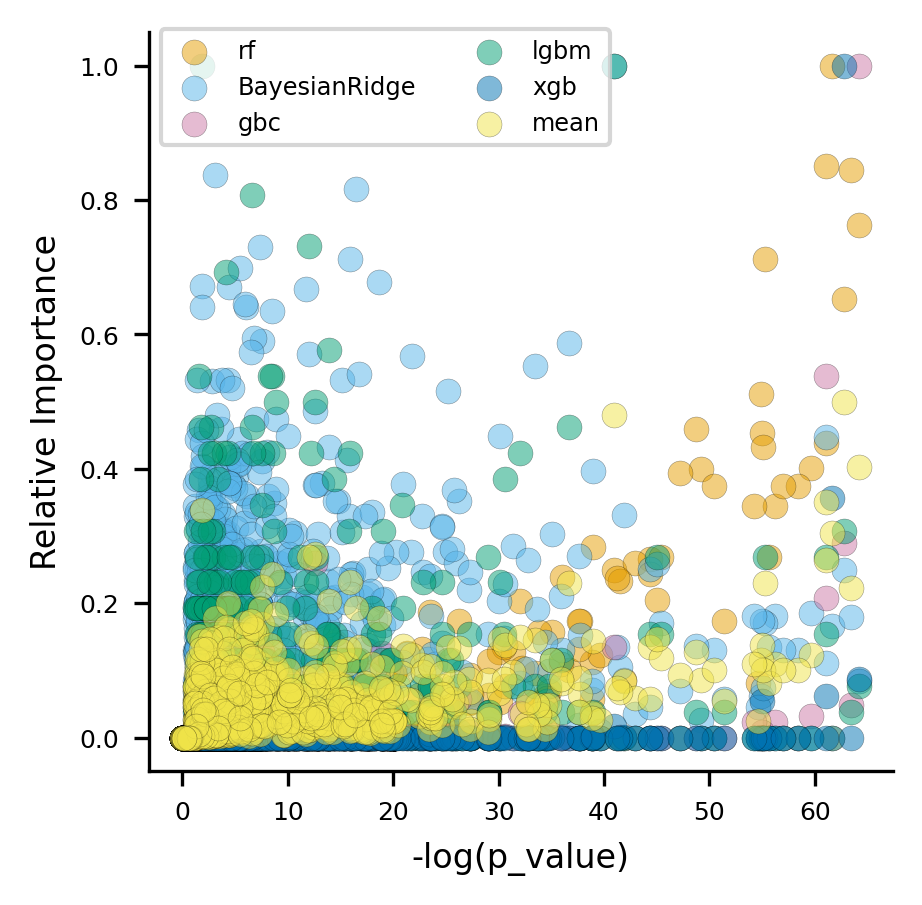

In [38]:
scatter_plot = plot_scatter(summary_result=sr, report_dir=report_dir)

In [39]:
%%time
mean_imp = mean_importance(top, report_dir=report_dir)

CPU times: total: 156 ms
Wall time: 151 ms


mean Done


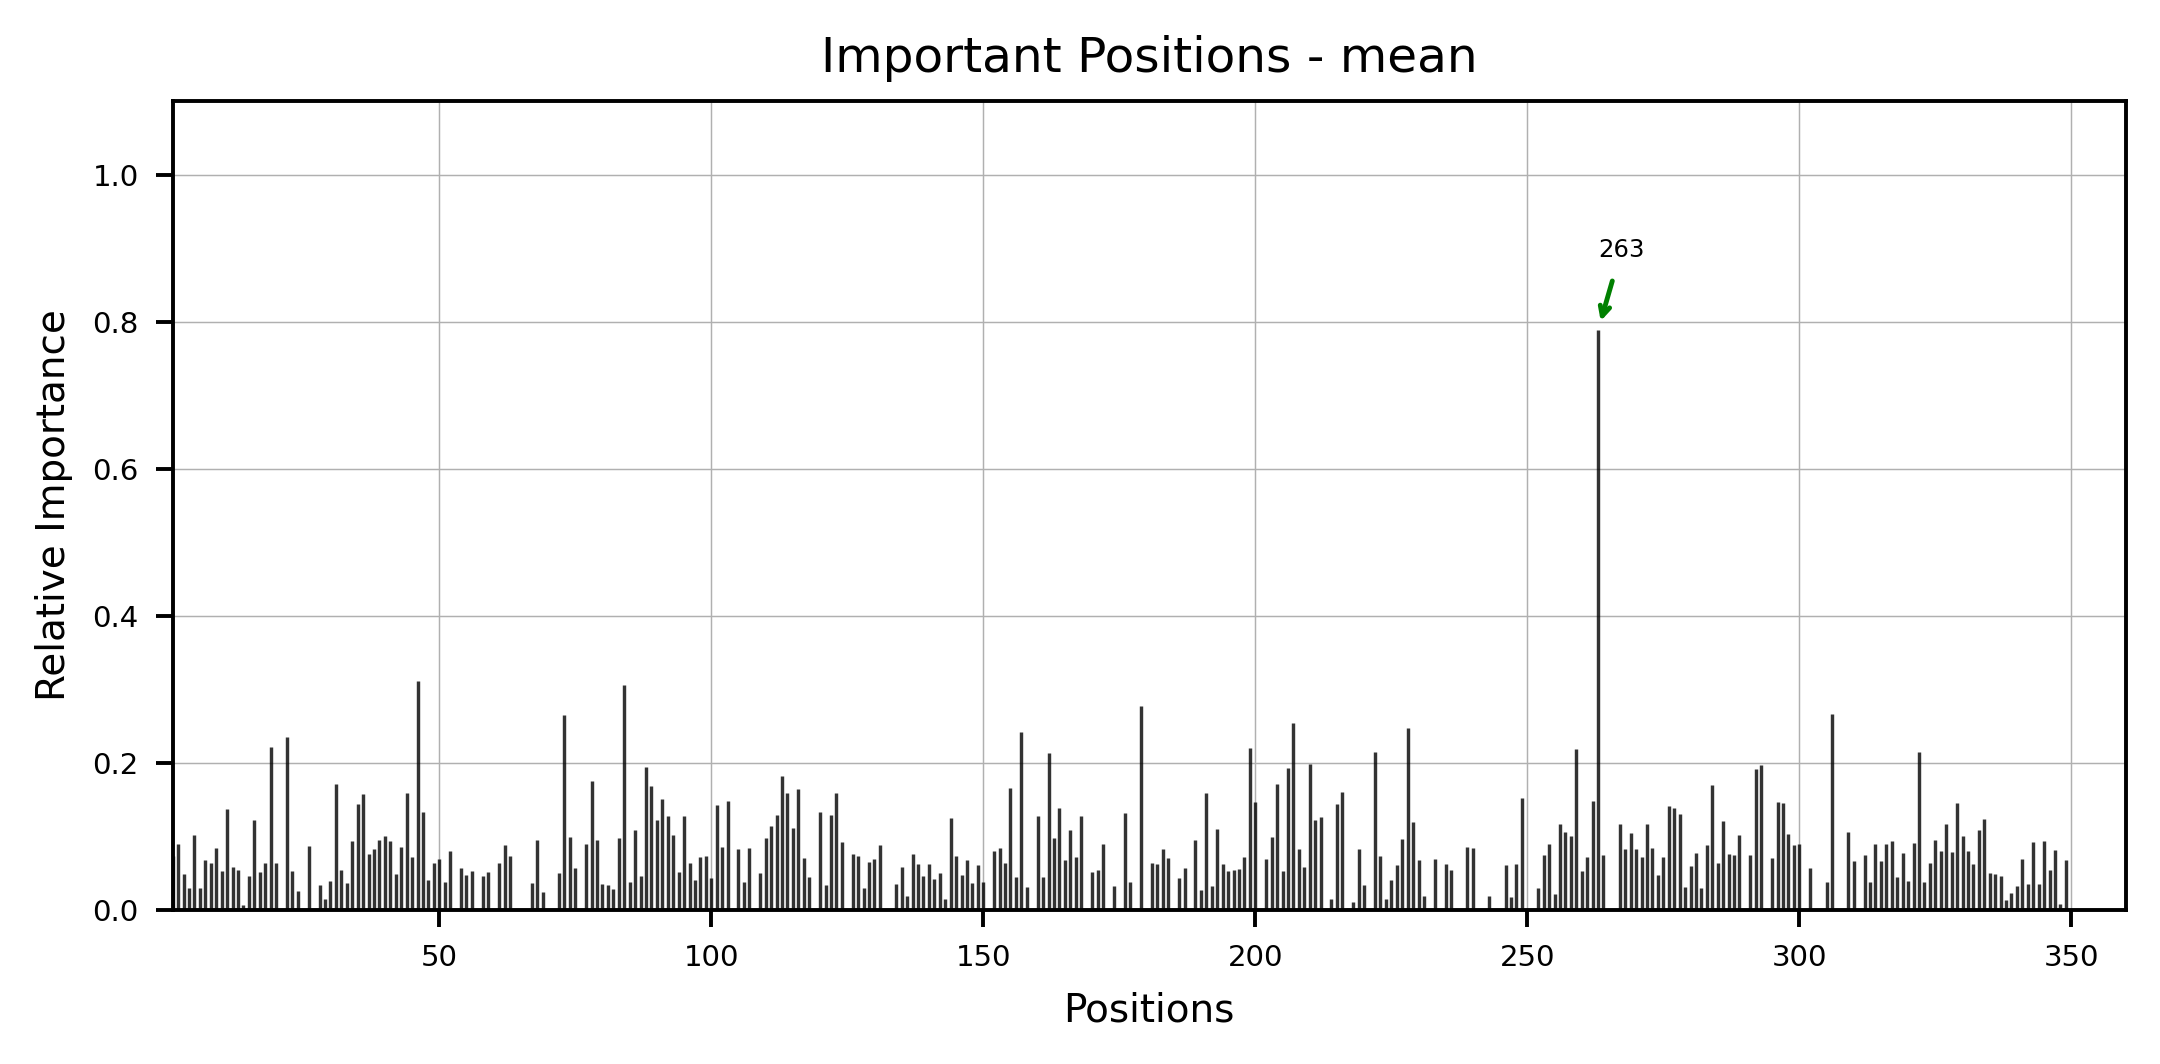

In [40]:
dp_plot(importance=mean_imp,imp_col='mean', model_name='mean', report_dir=report_dir)

In [41]:
tr = prep_pipeline[:4].fit_transform(tr)

rf Done
rf  Done
BayesianRidge Done
BayesianRidge  Done
gbc Done
gbc  Done
lgbm Done
lgbm  Done
xgb Done
xgb  Done


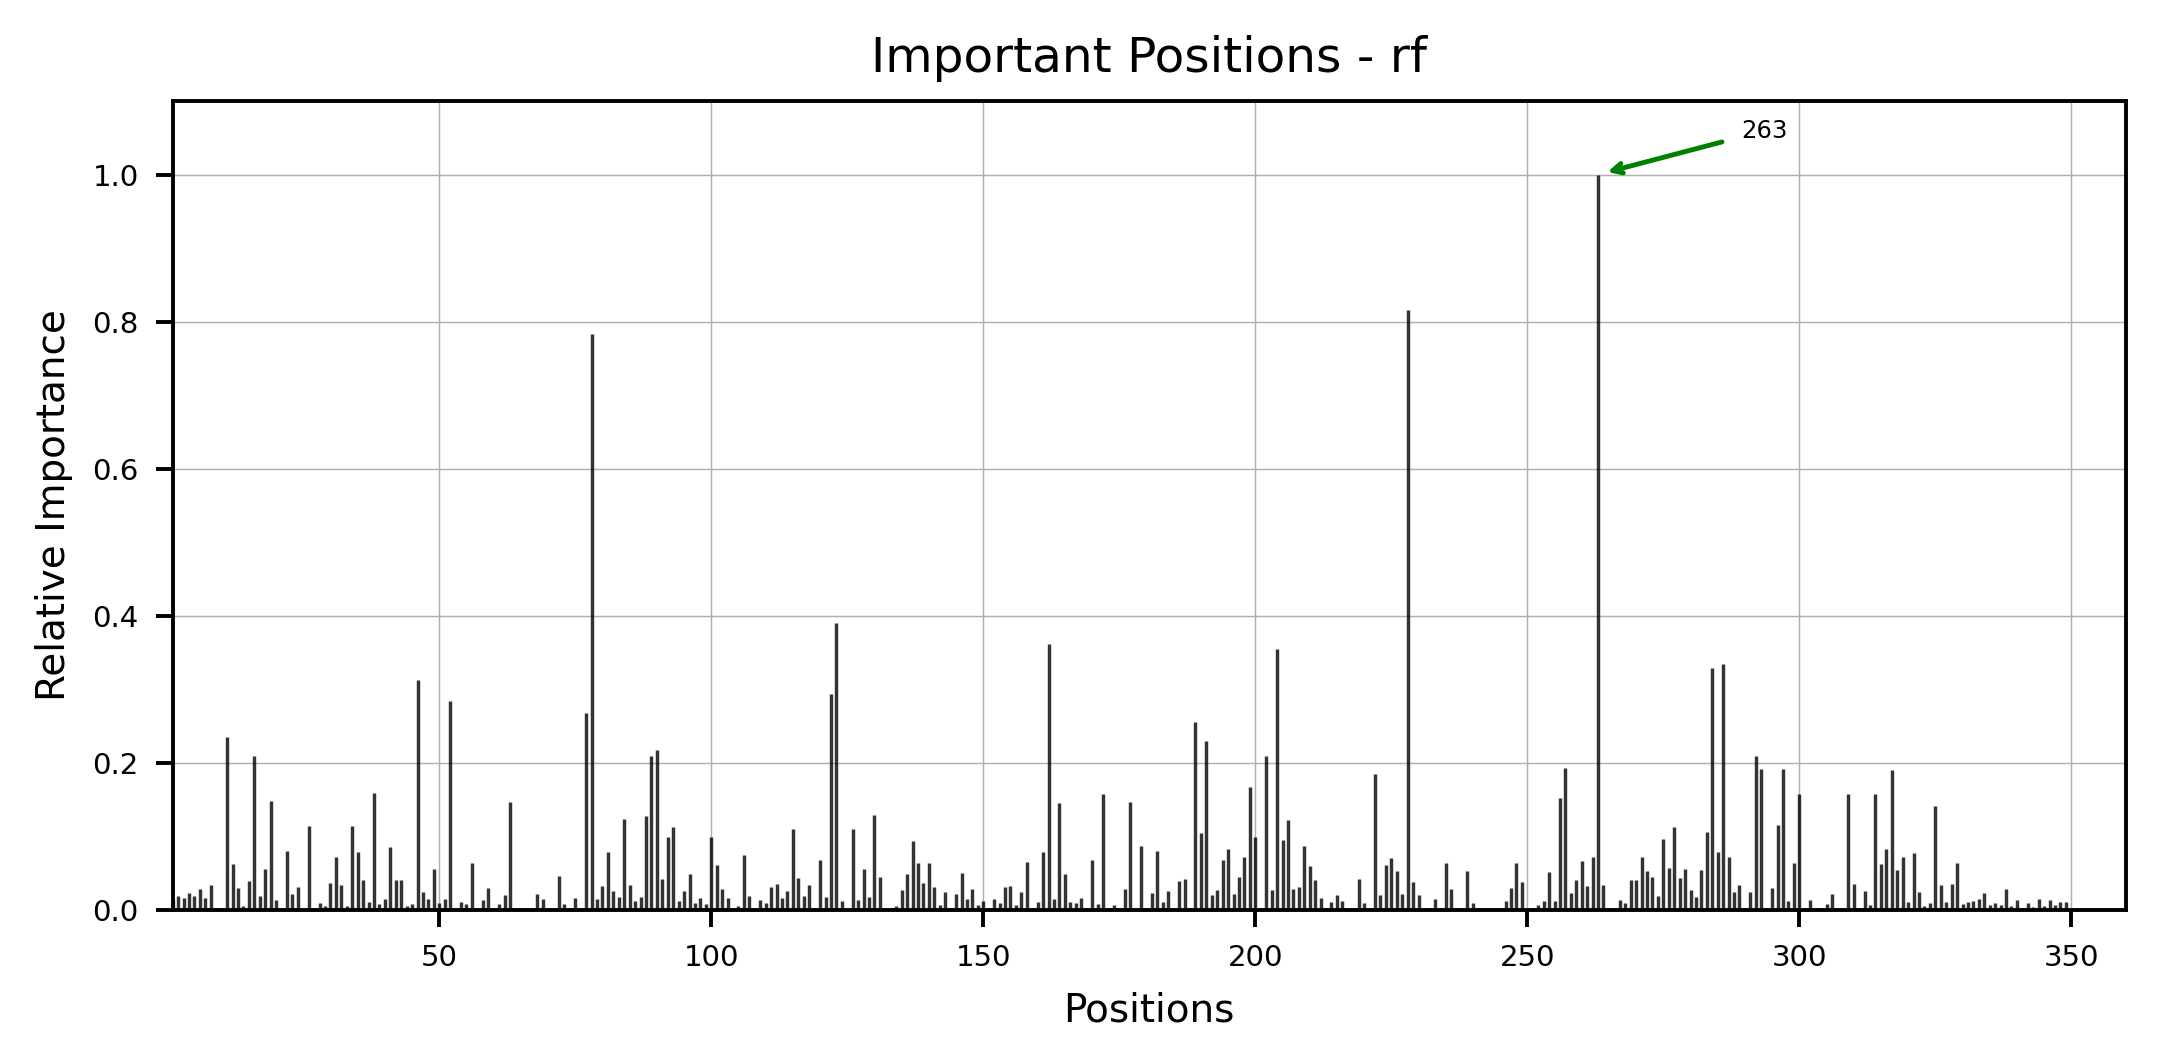

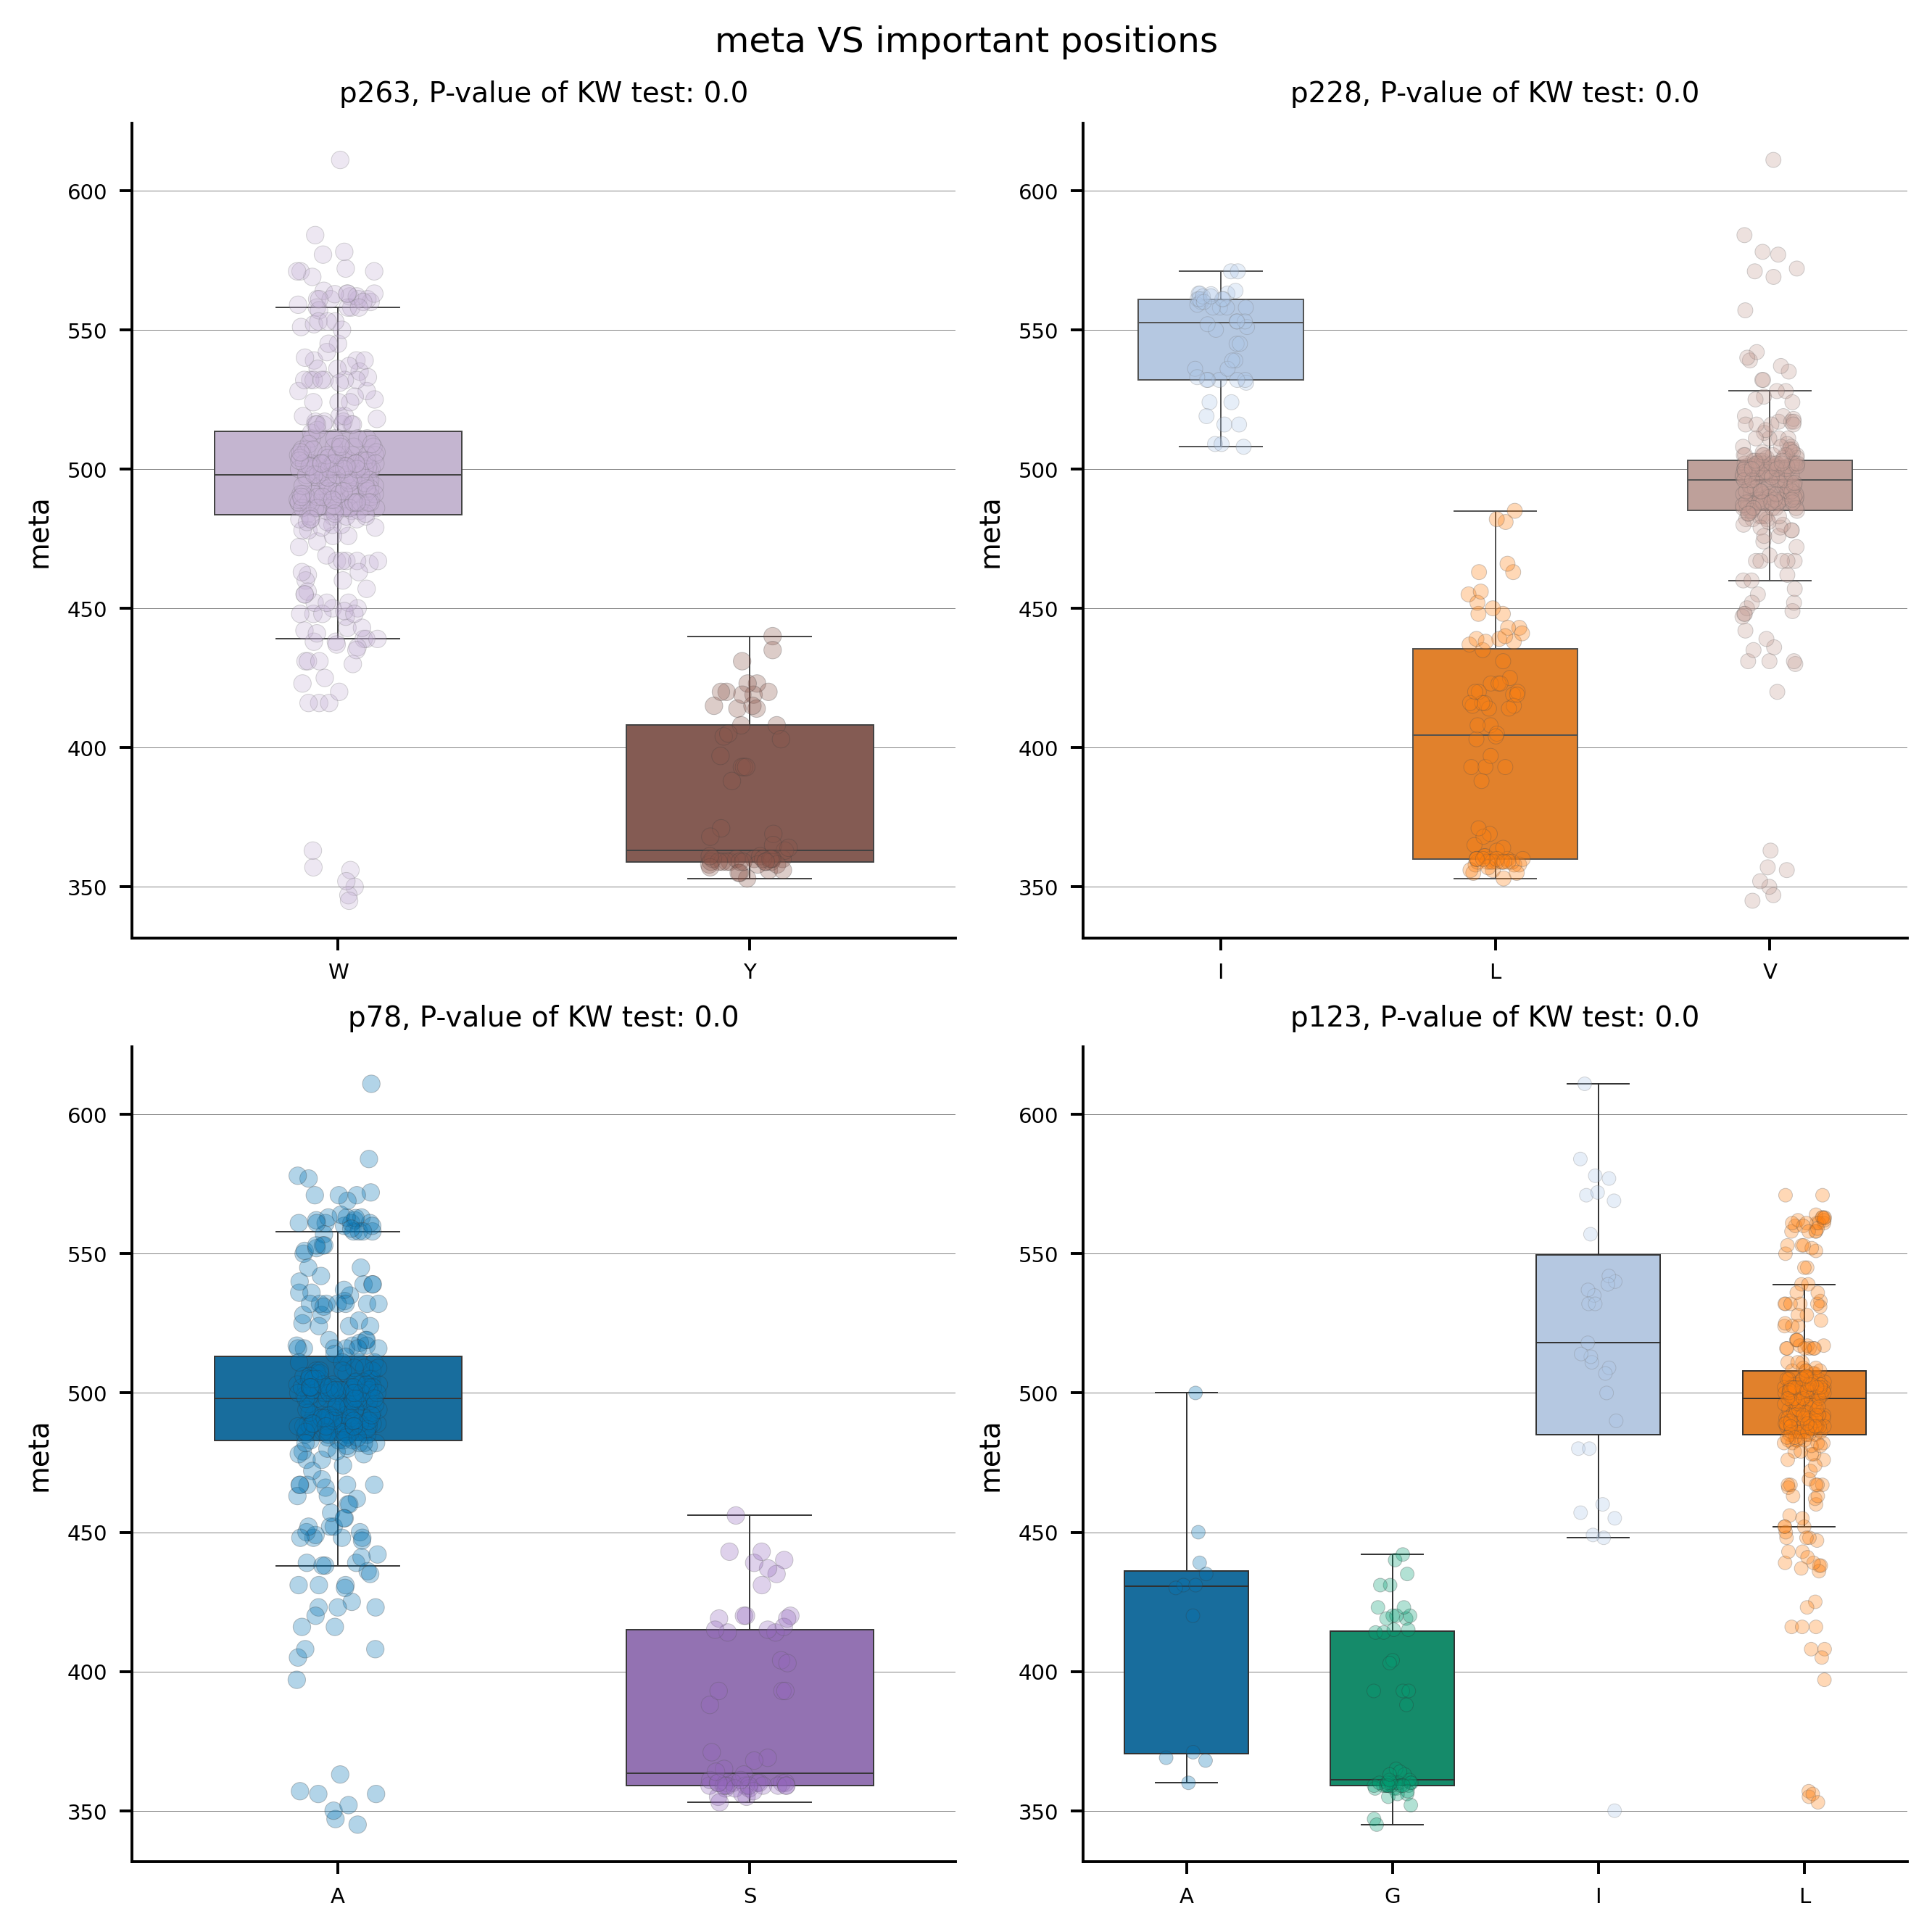

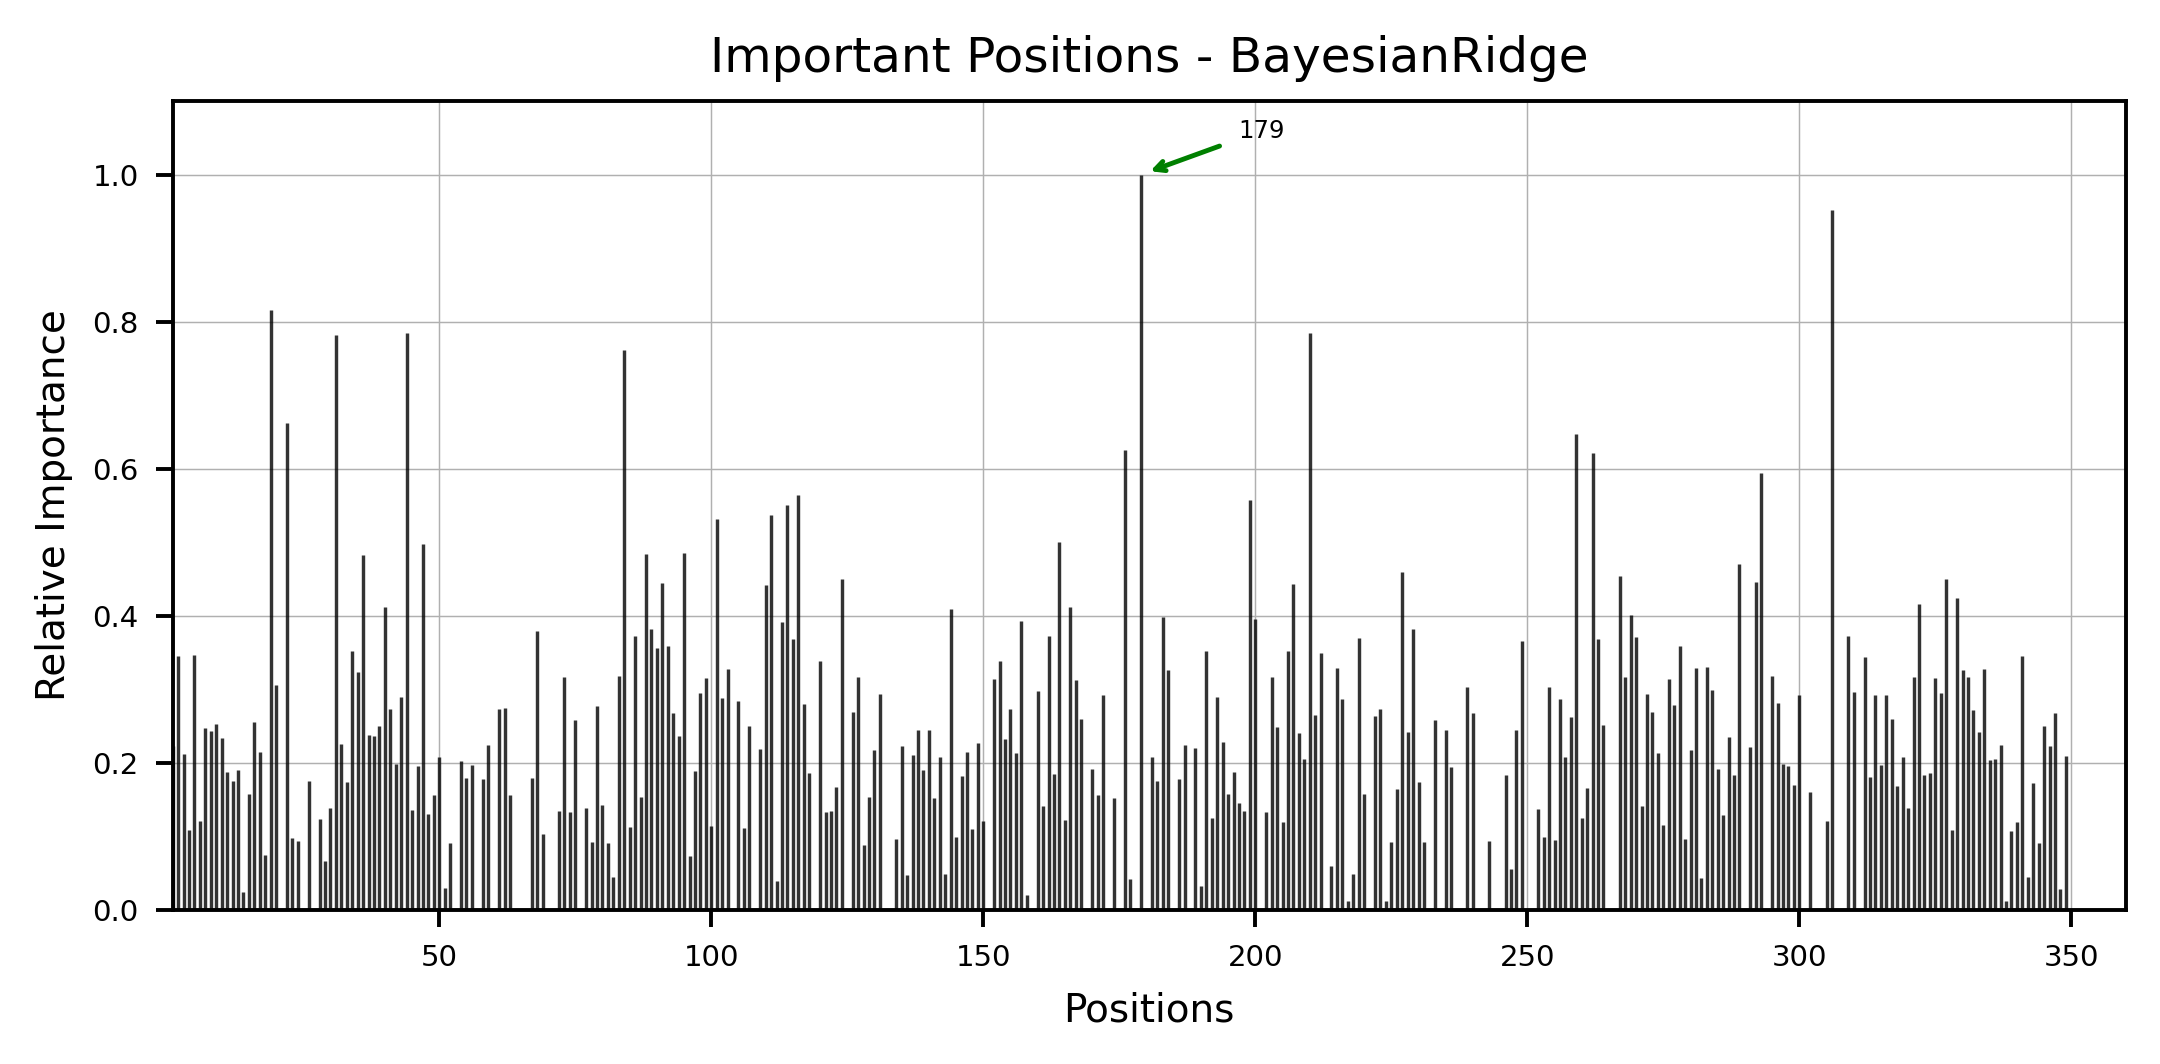

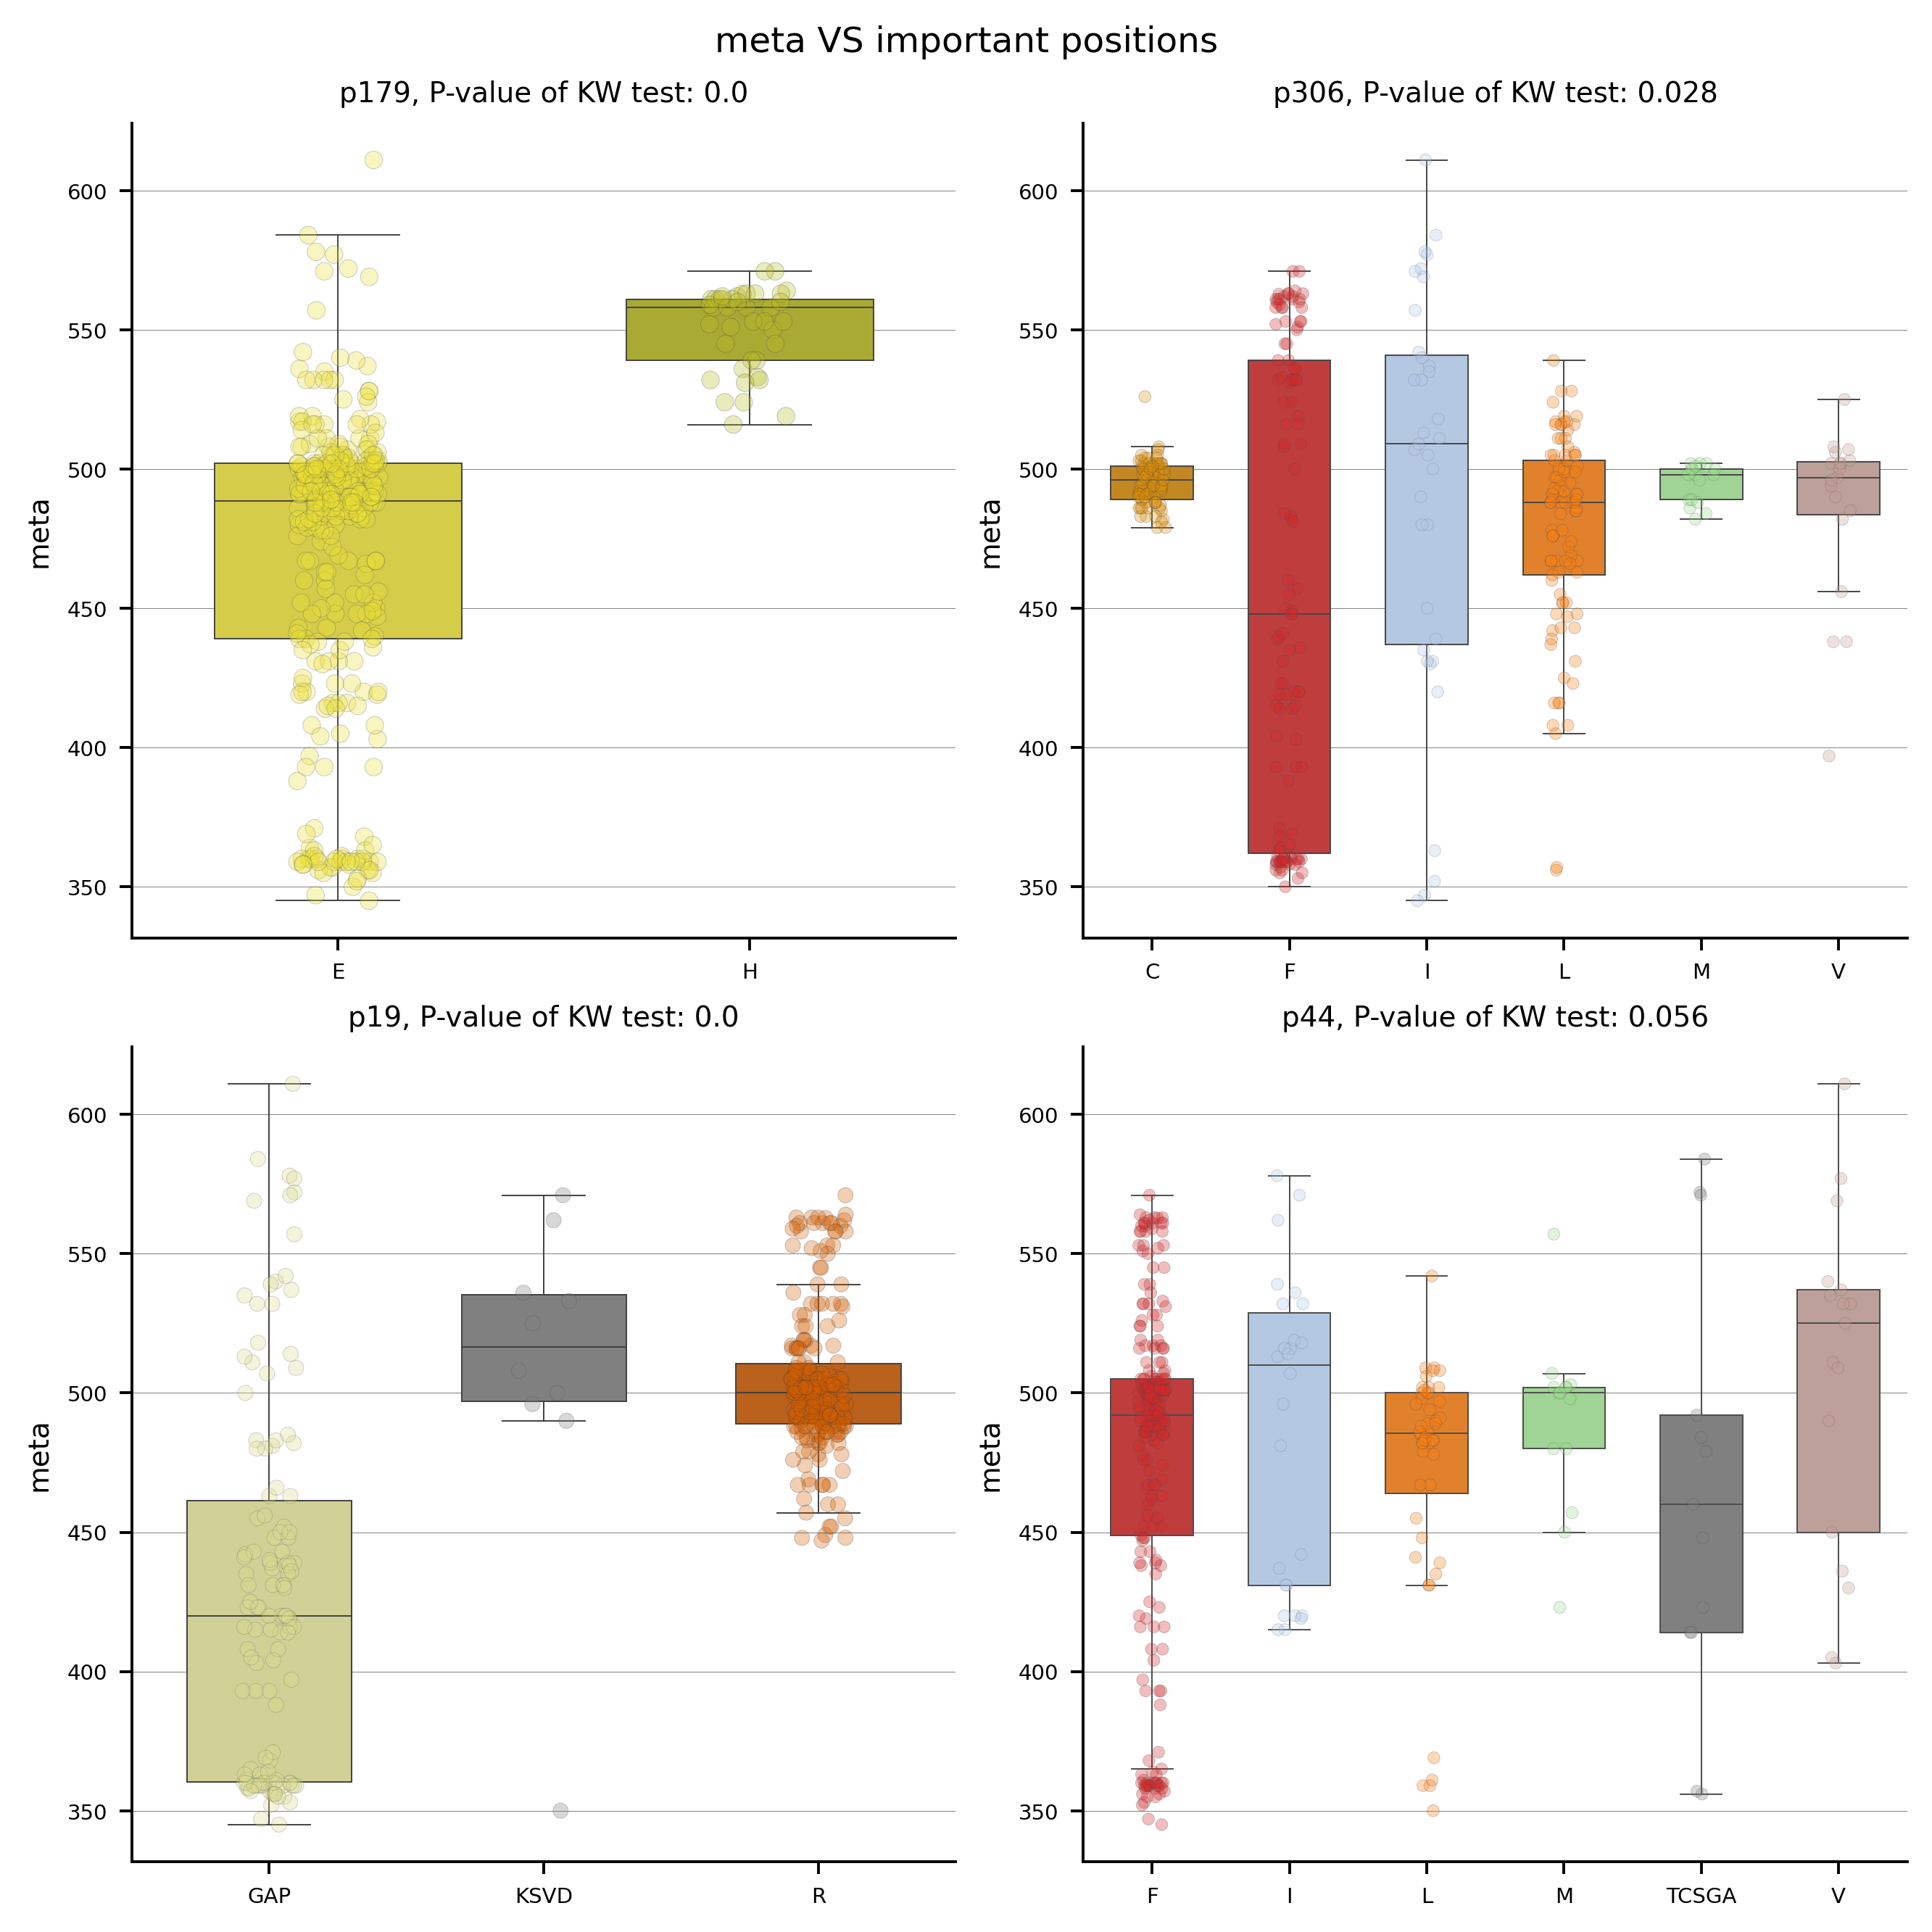

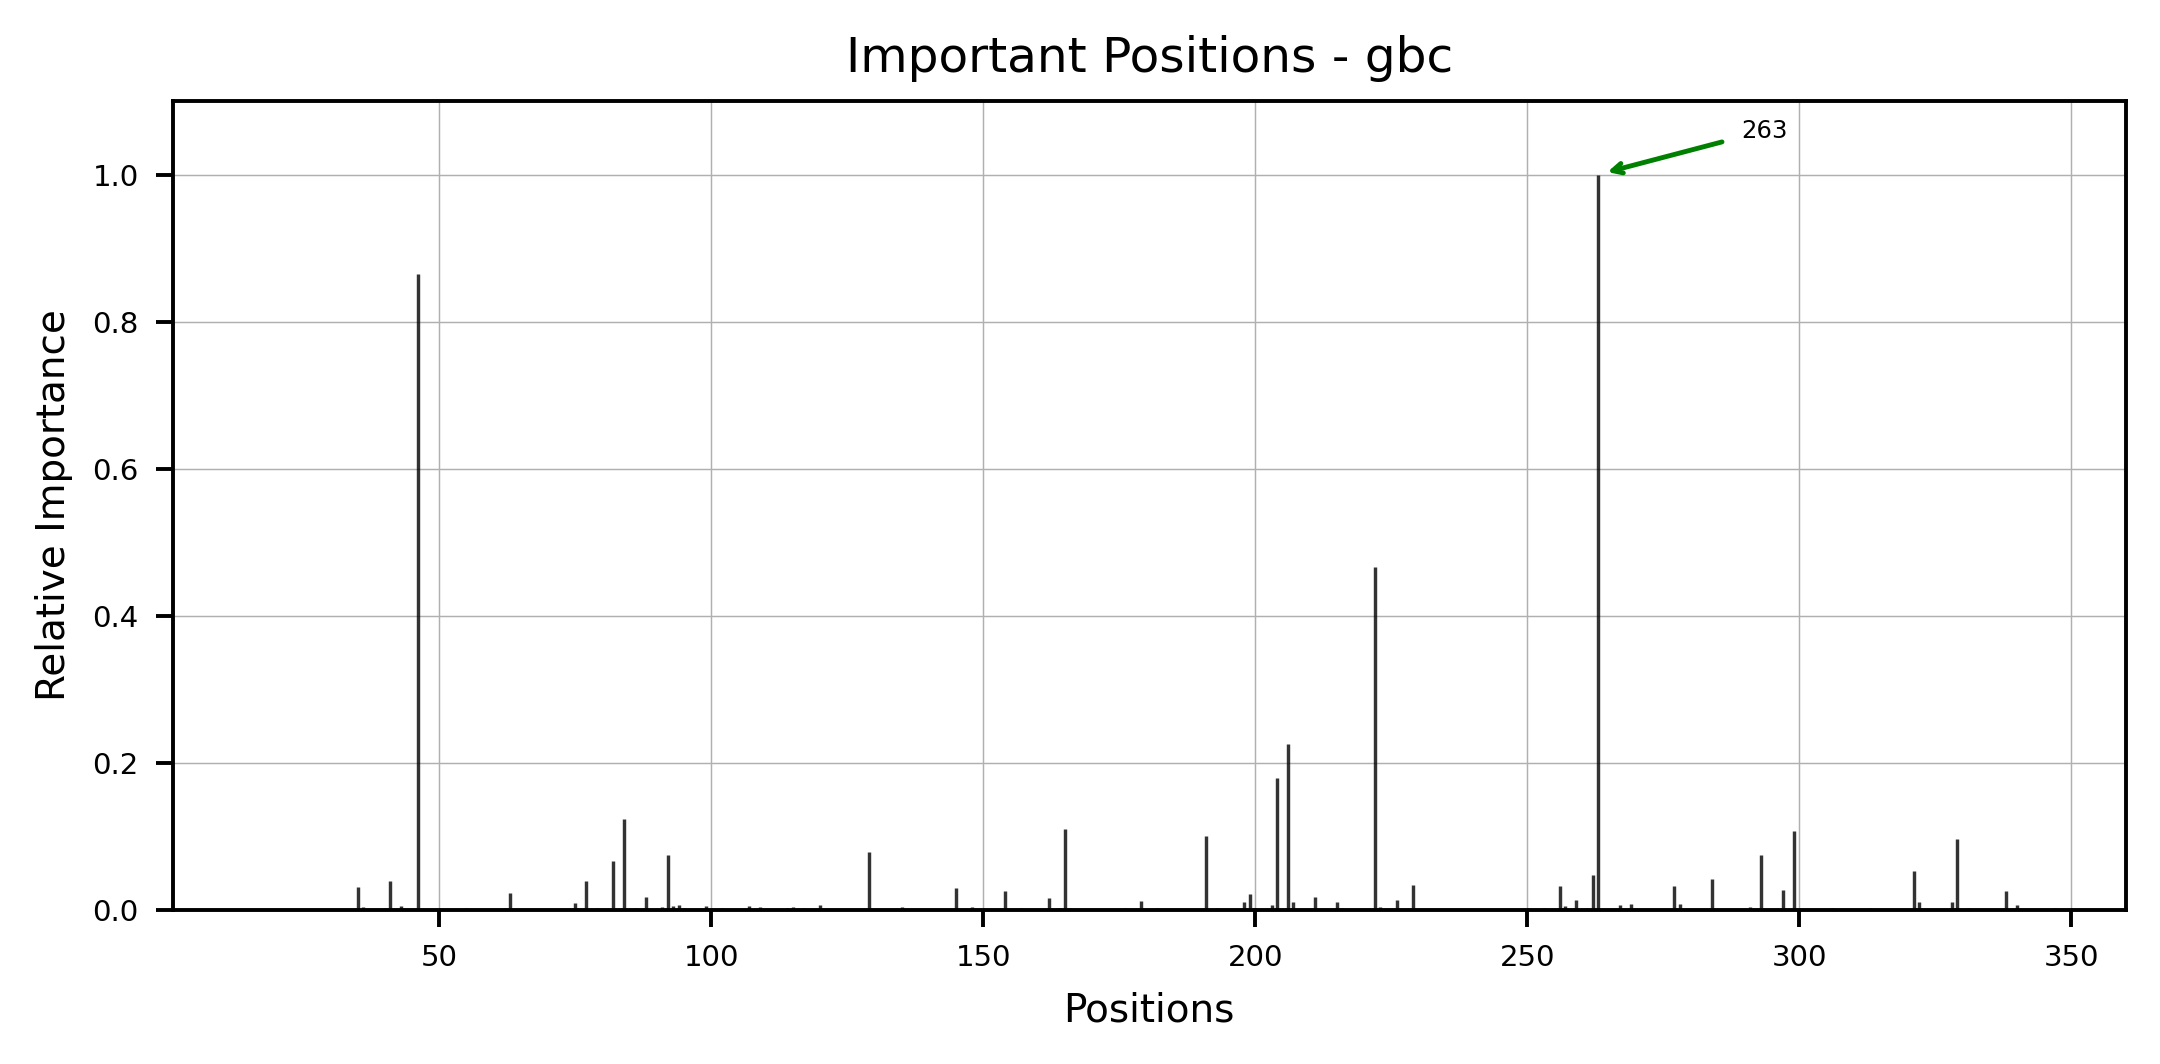

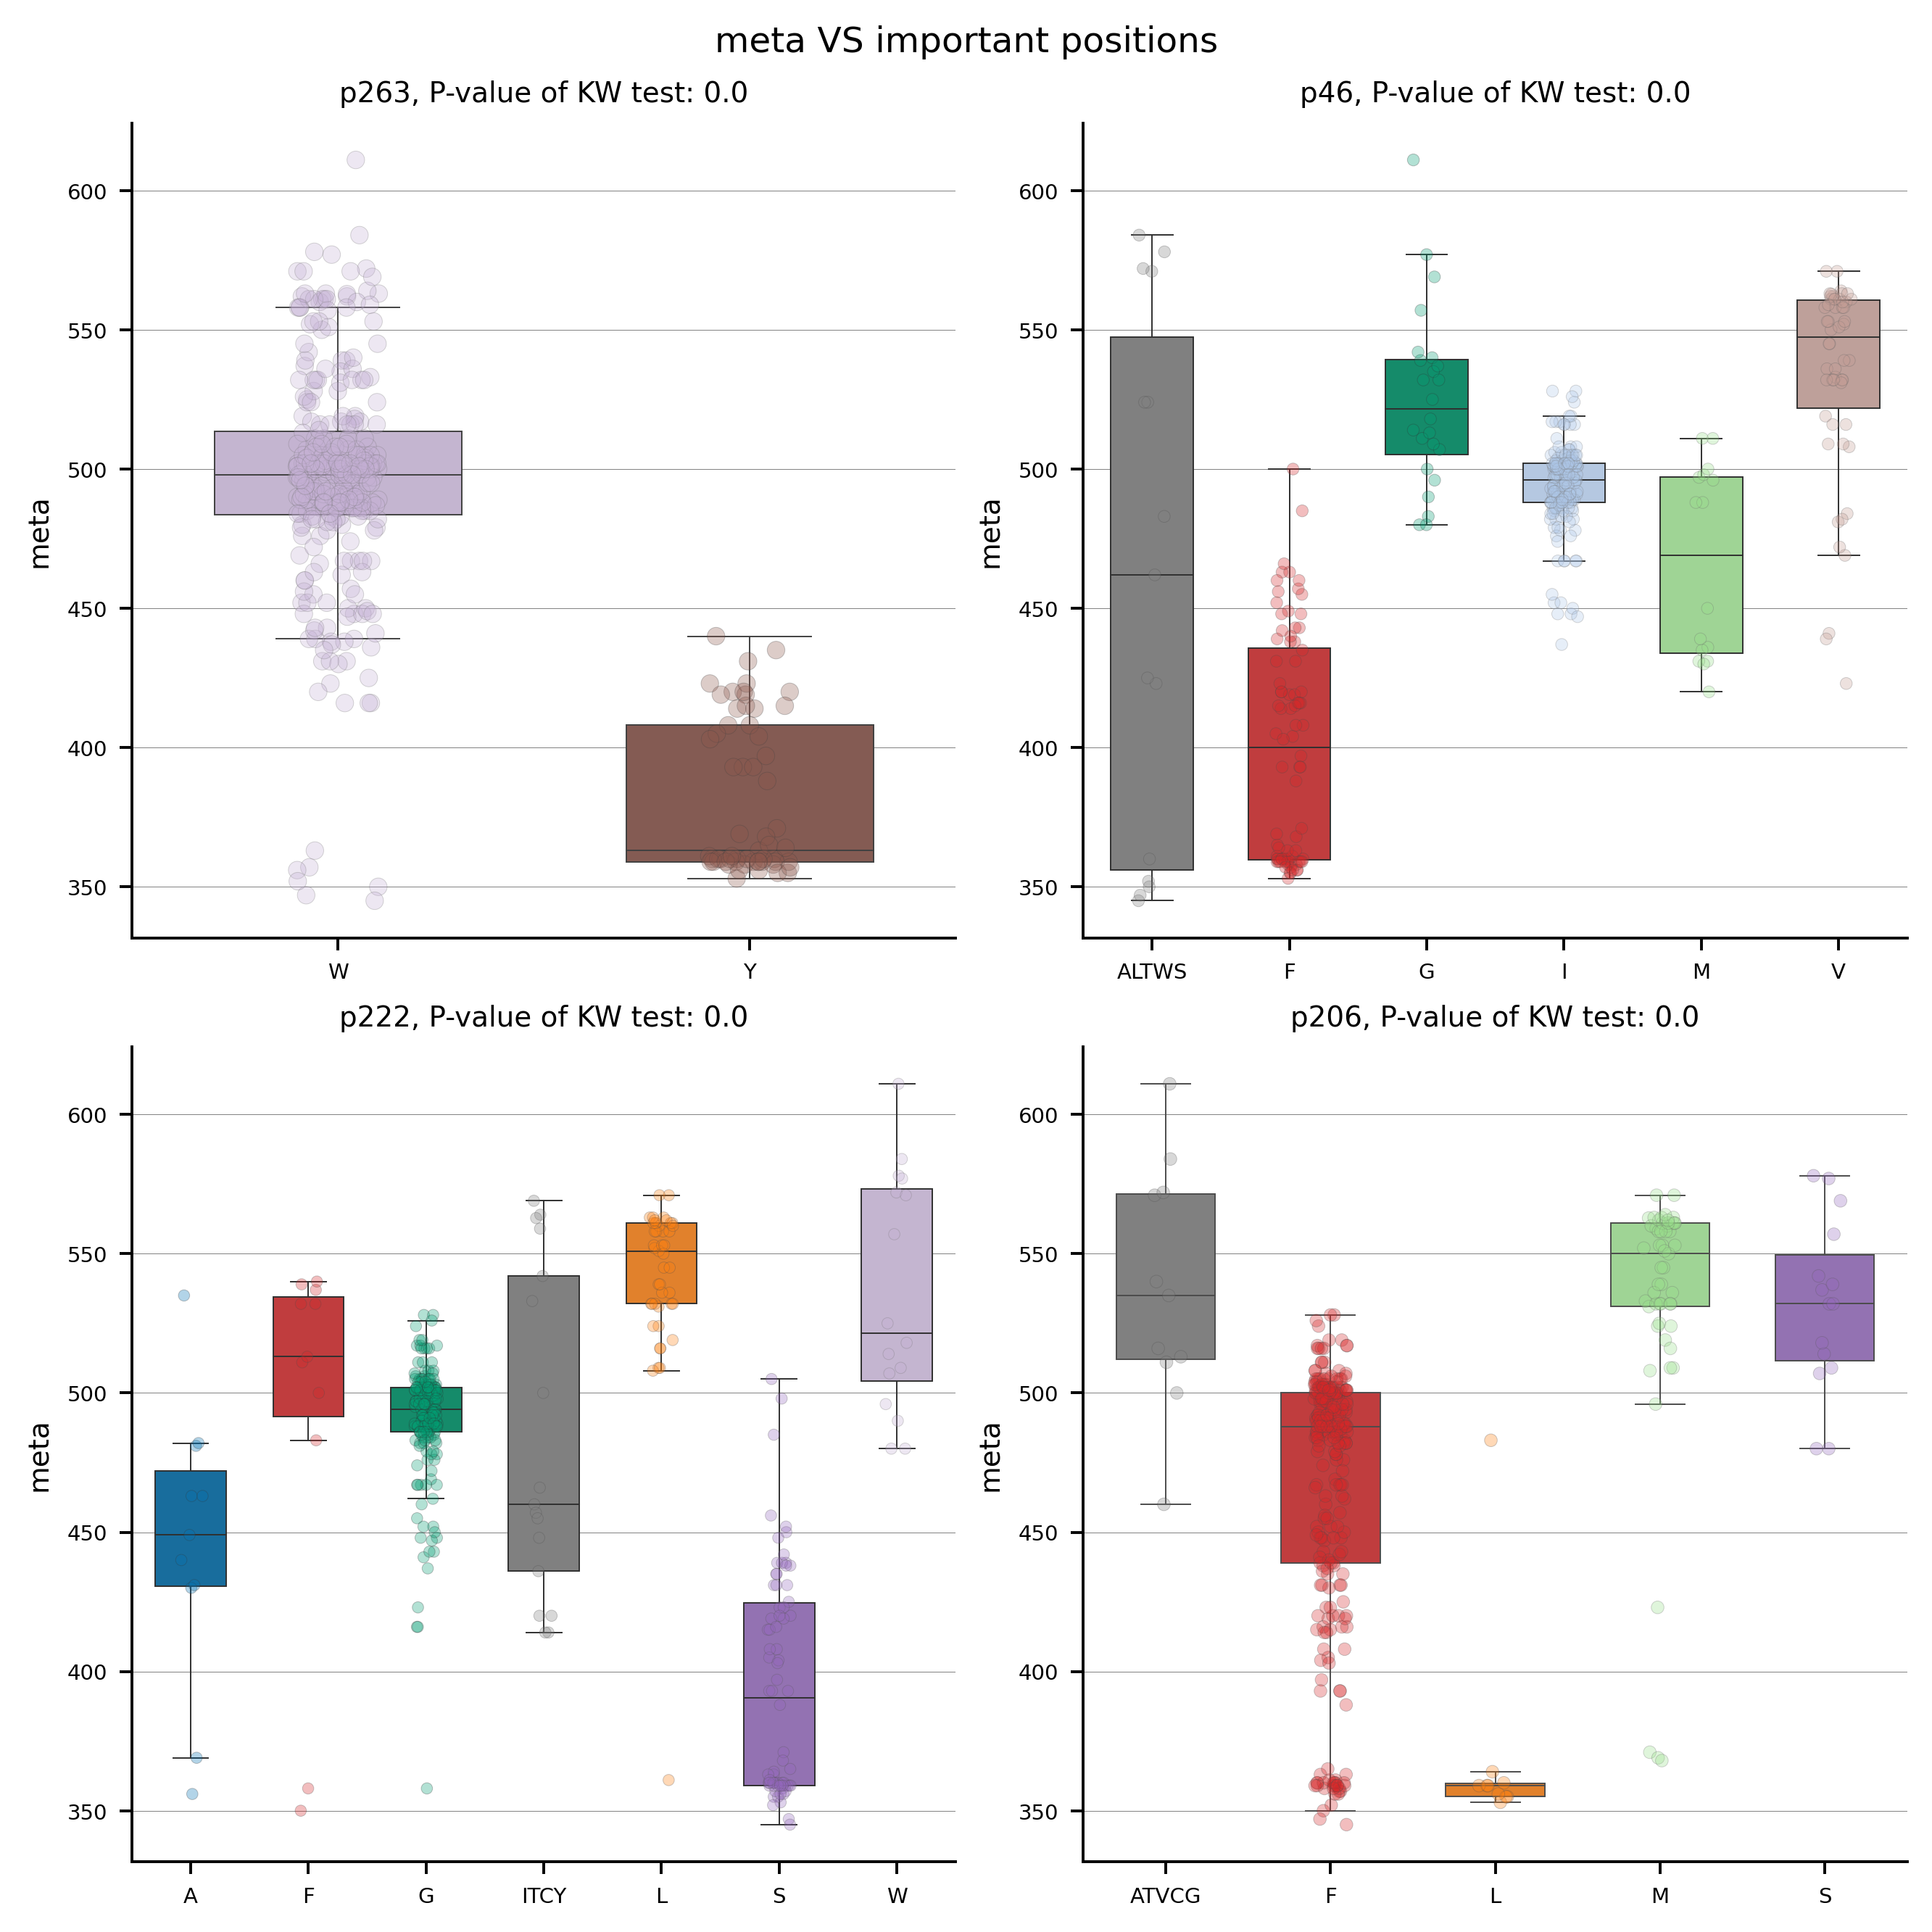

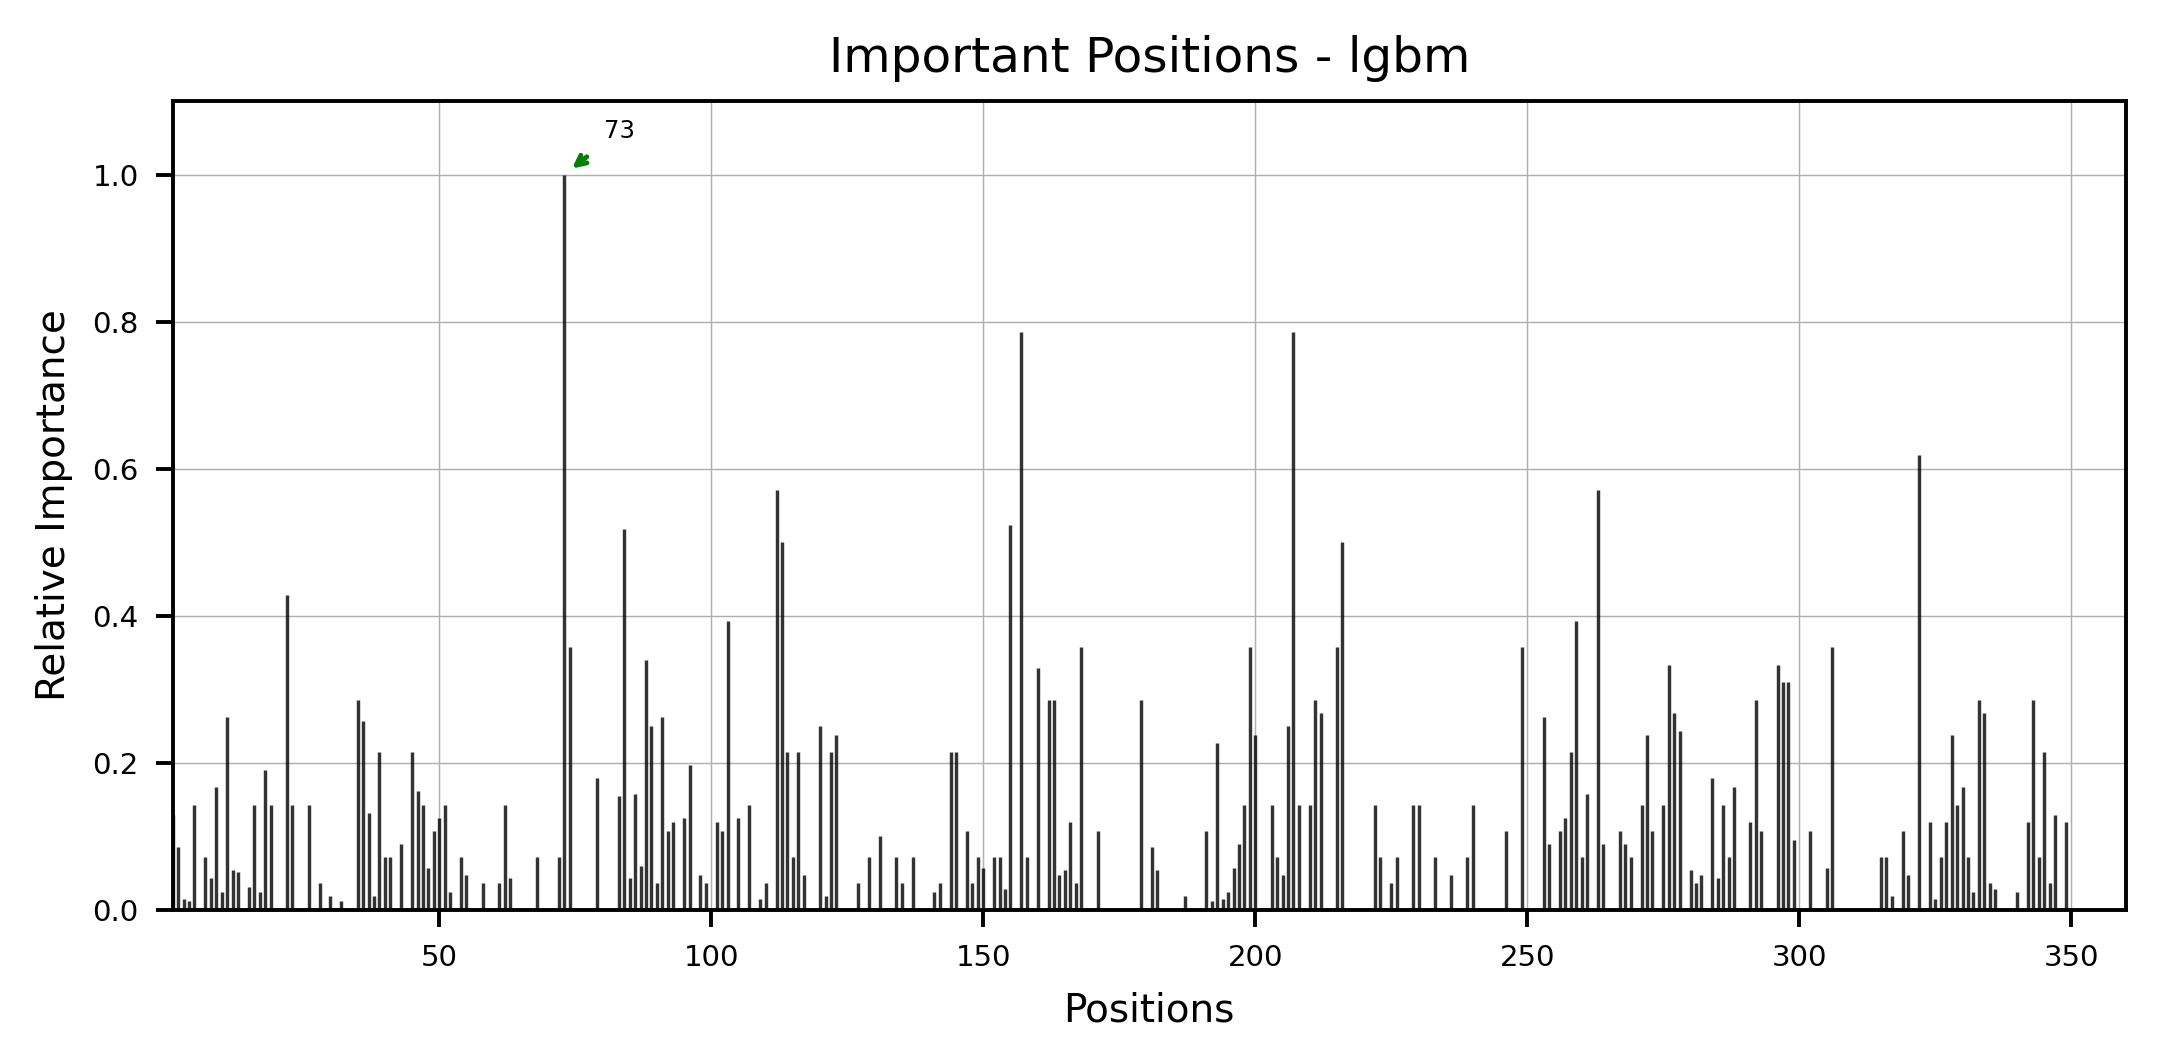

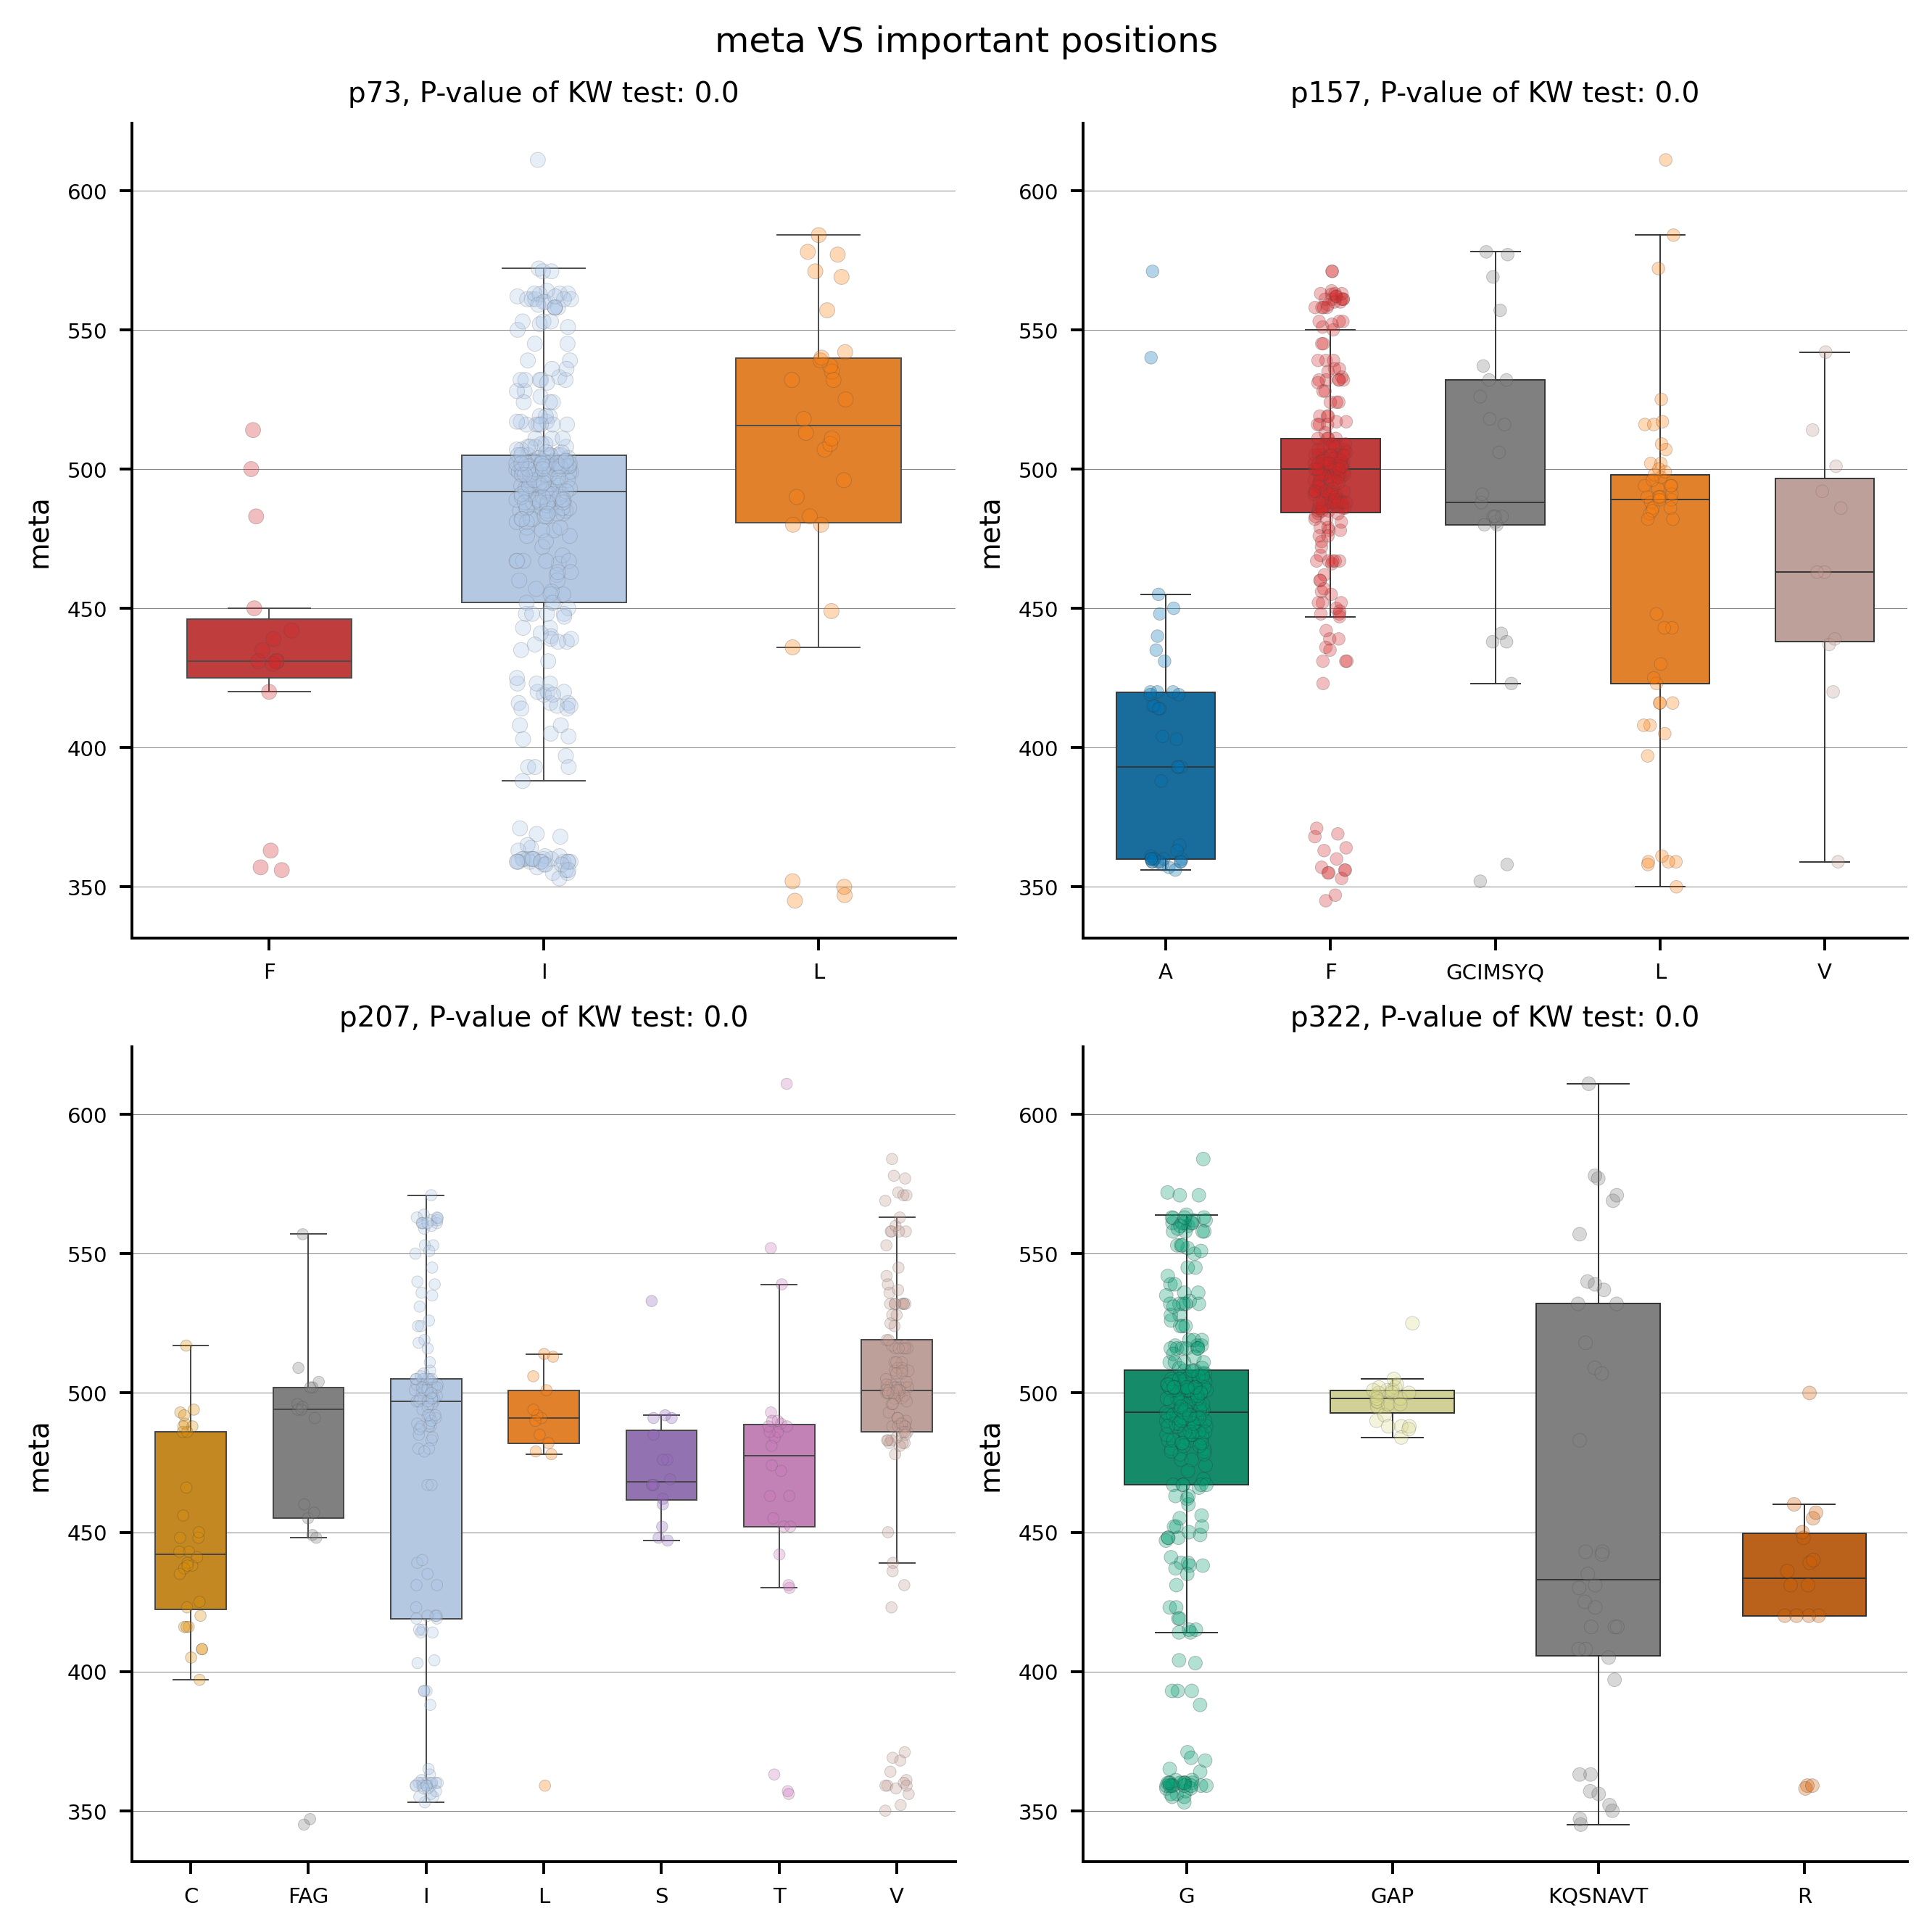

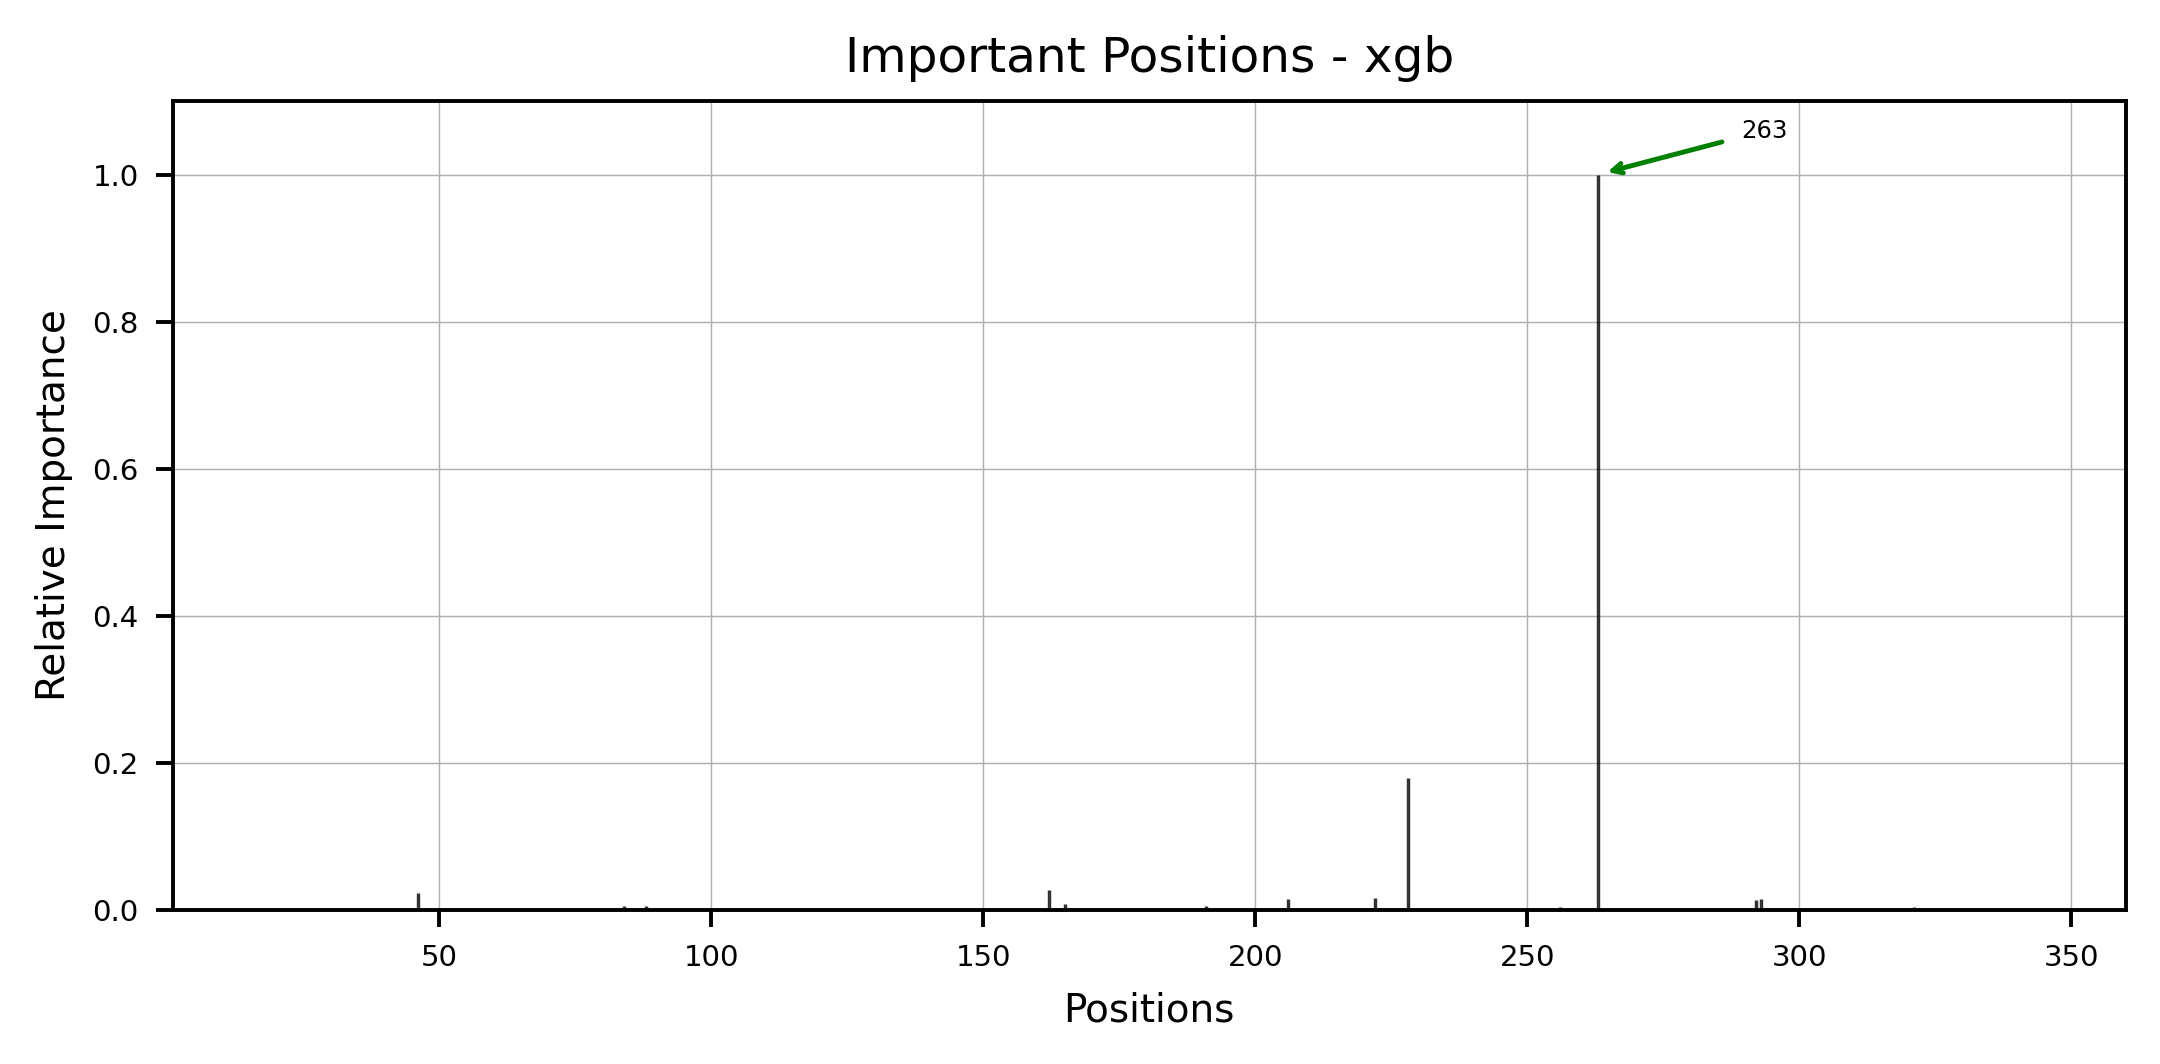

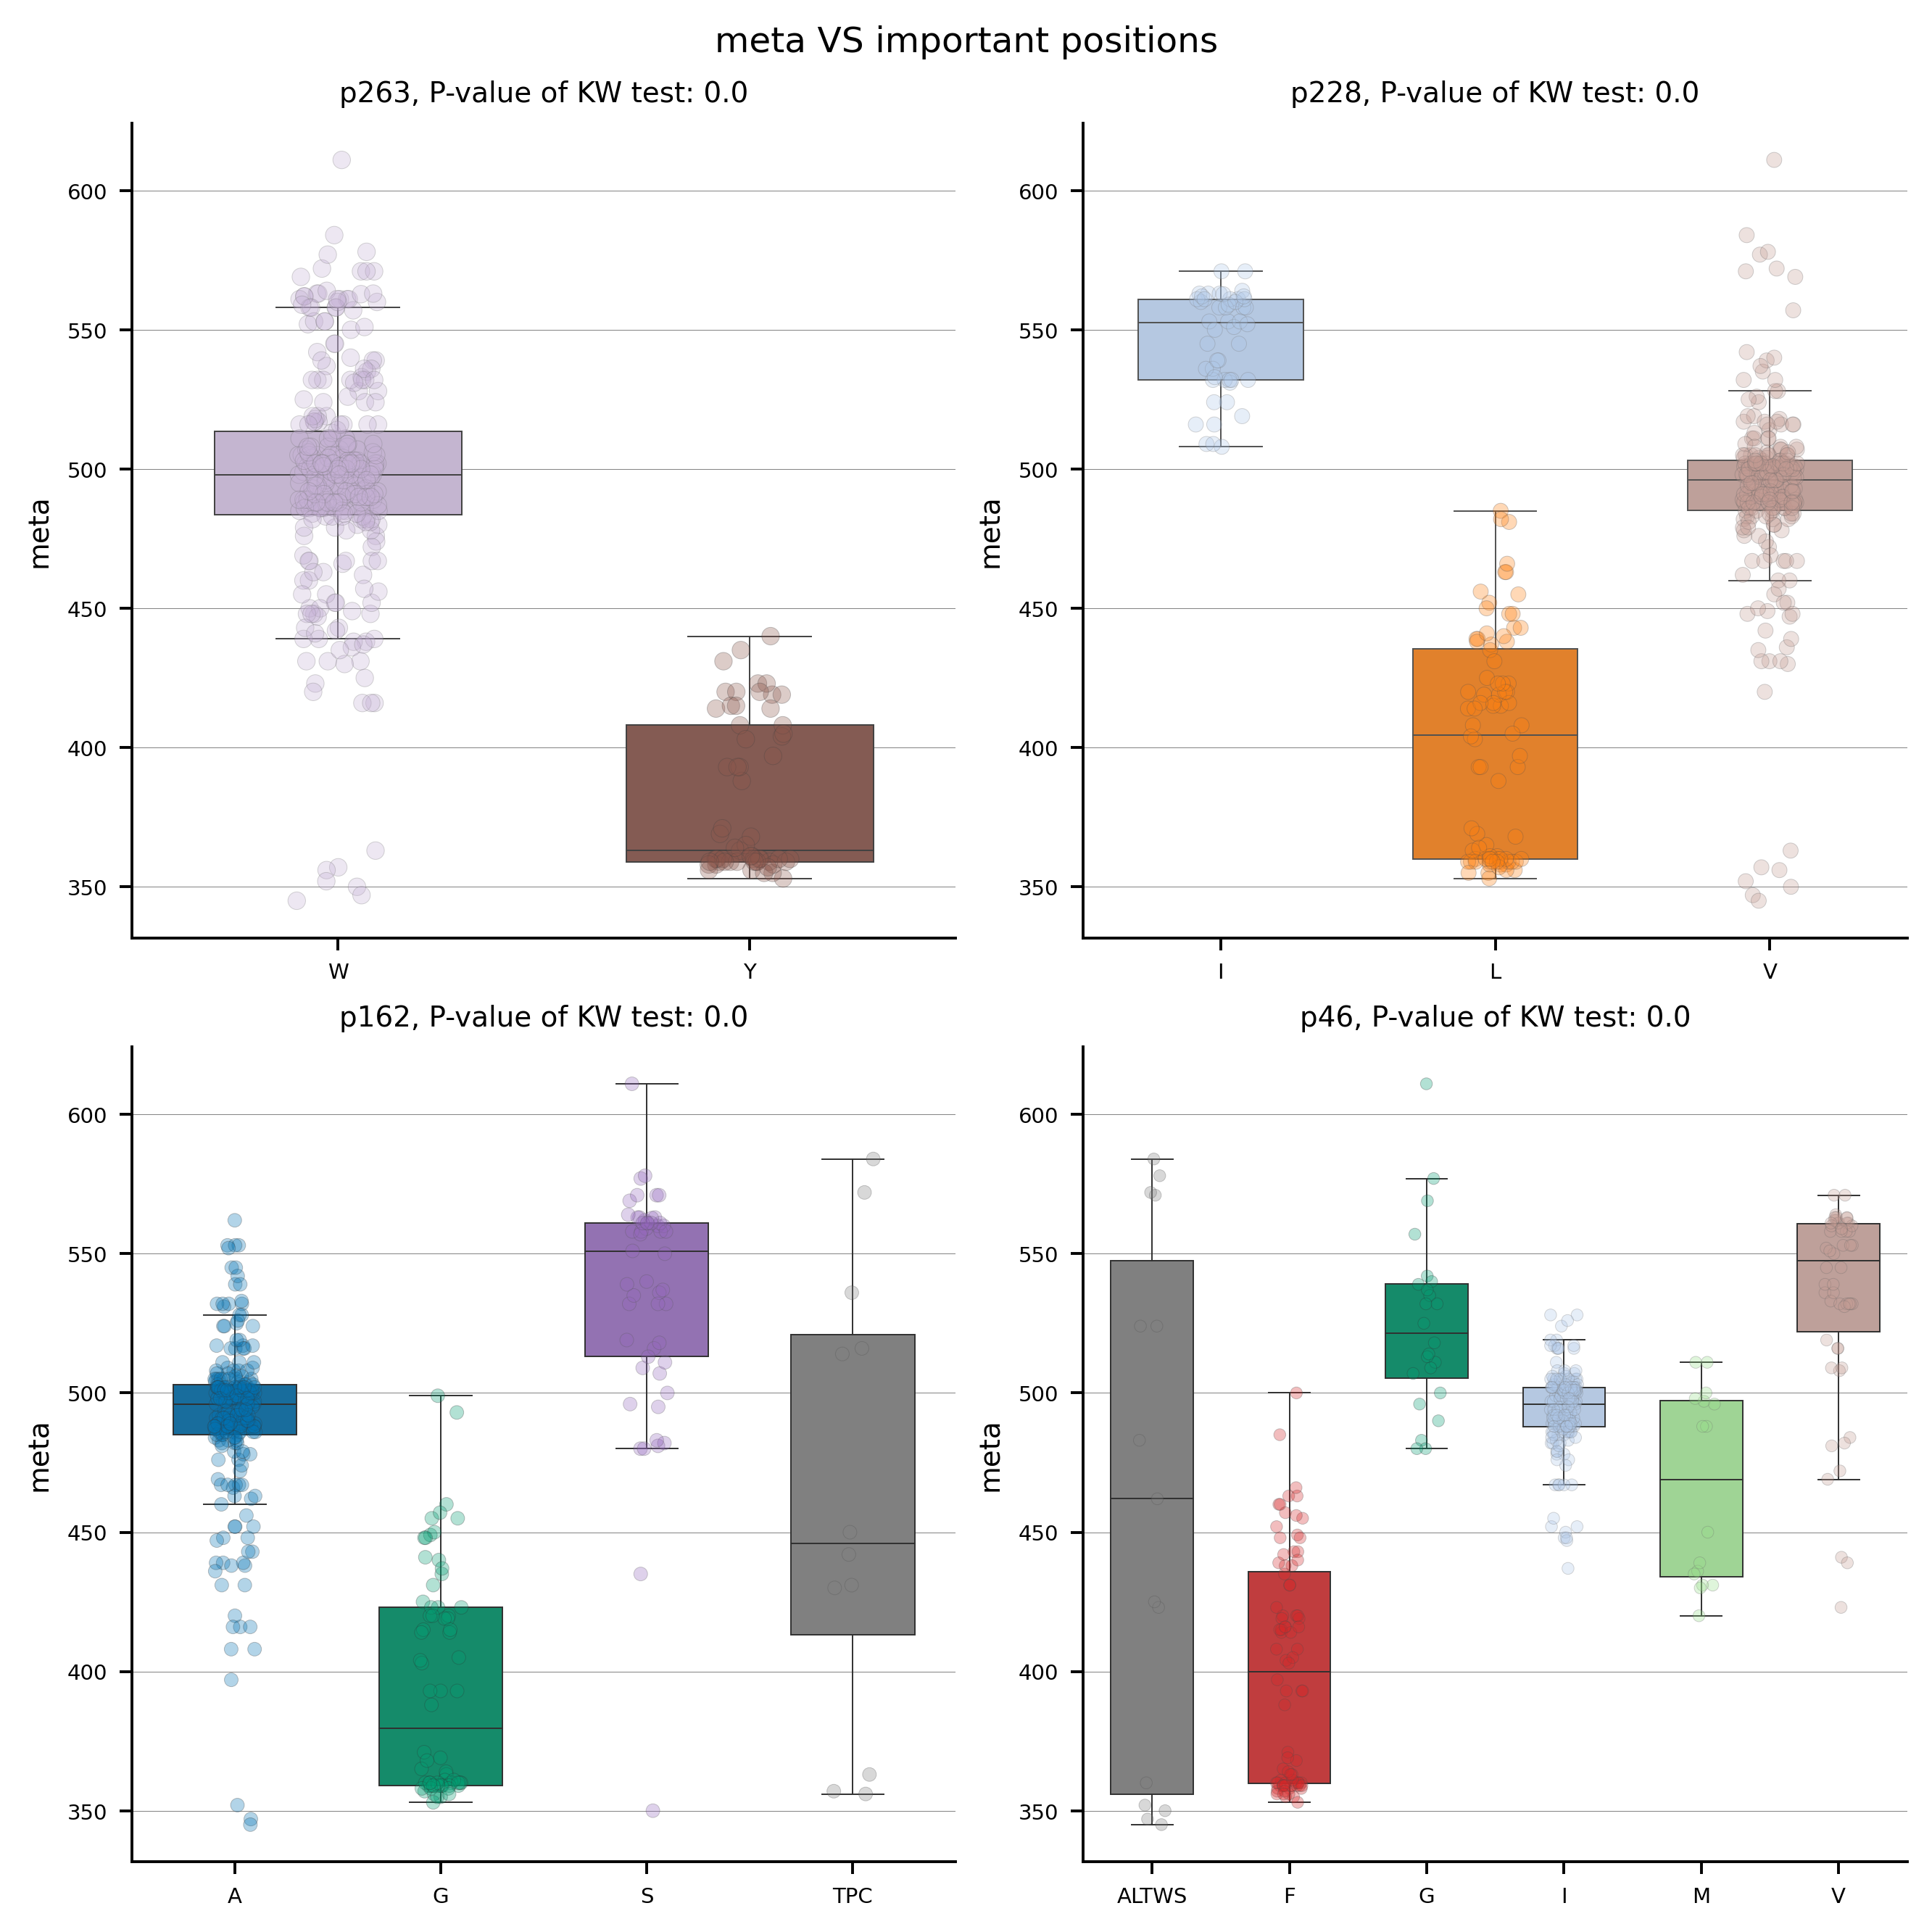

In [42]:
for model in top:
    model_name = model.steps[-1][0]
    dp_plot(importance=importance_from_pipe(model),
            imp_col='standard_value',
            model_name = model_name, report_dir=report_dir)
    
    plot_imp_model(importance=importance_from_pipe(model), 
               X_train=tr, y_train=y, model_name=model_name,
                   meta_var='meta', model_type=ana_type, report_dir=report_dir)

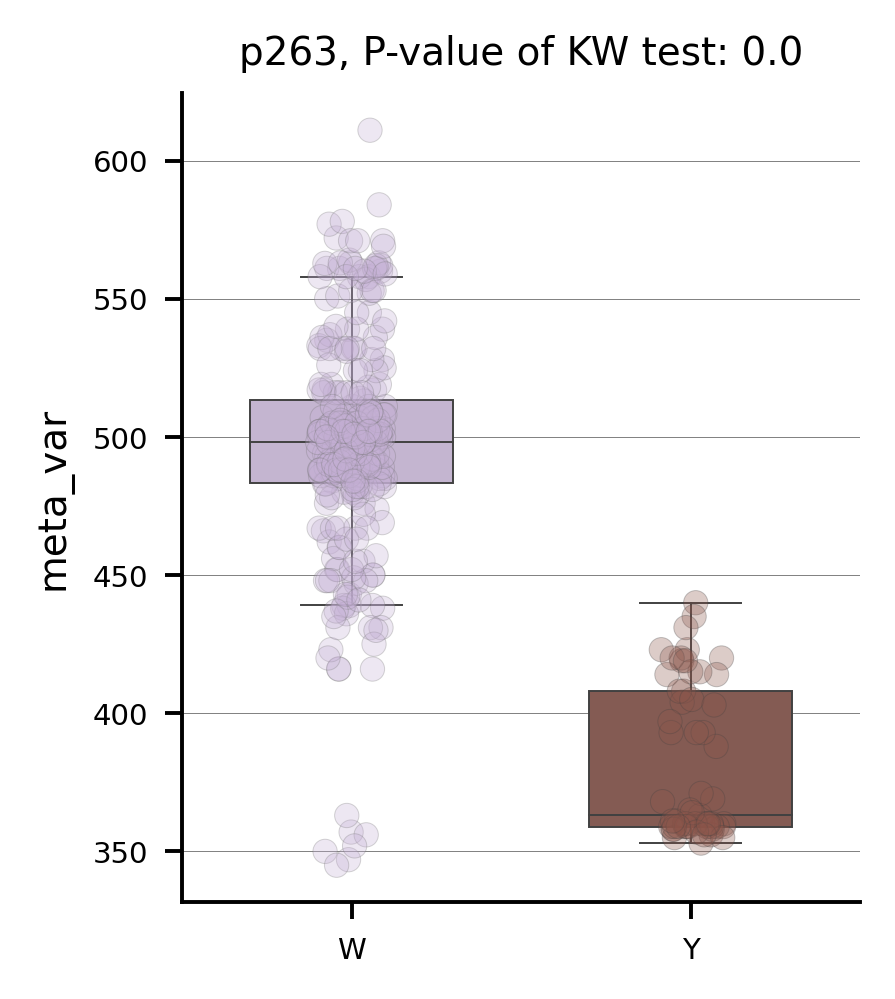

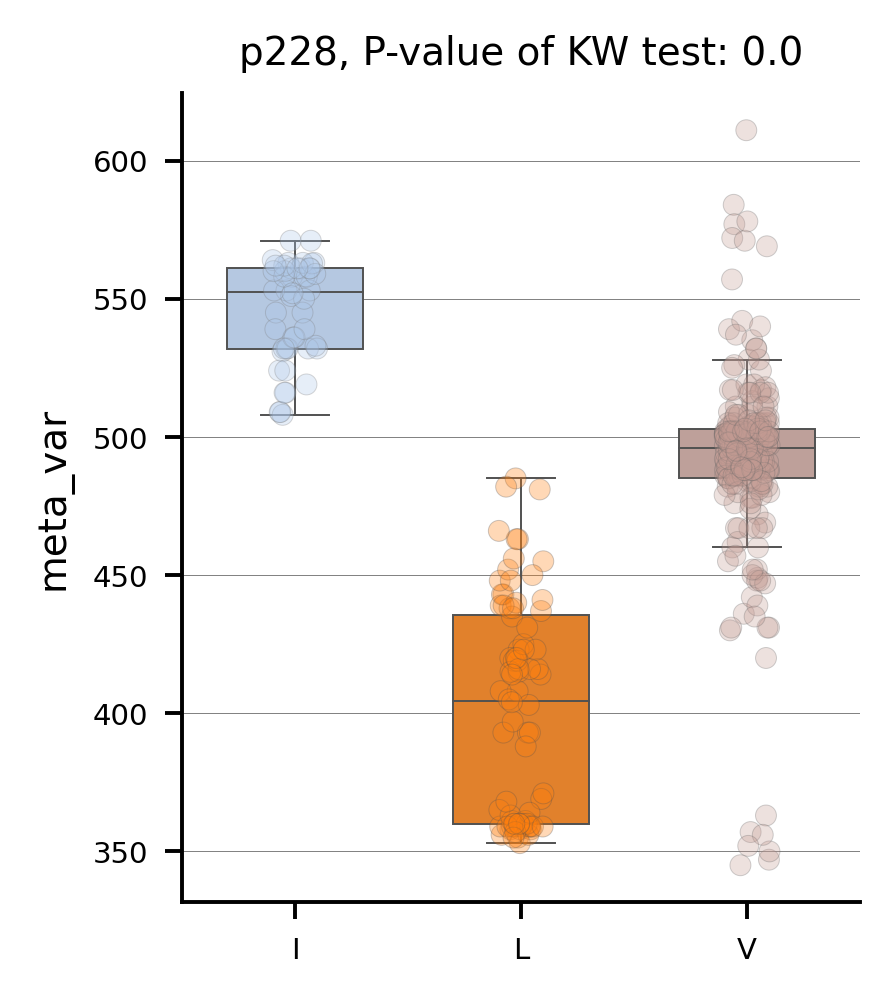

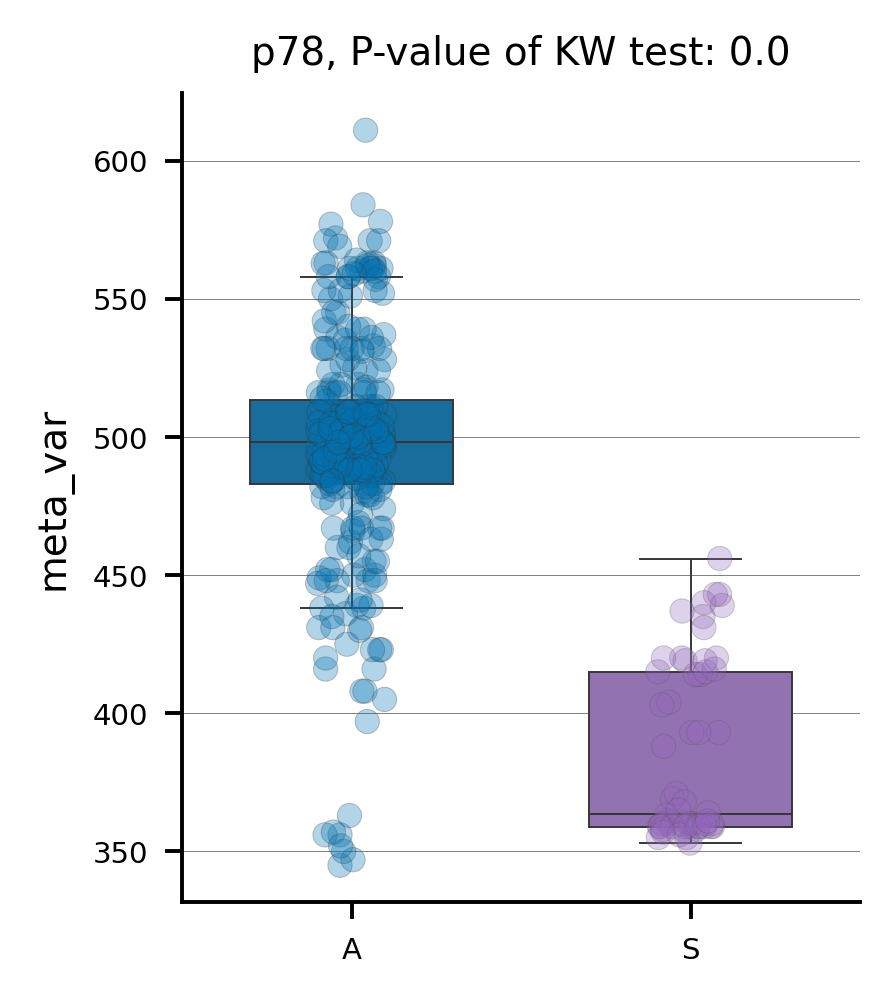

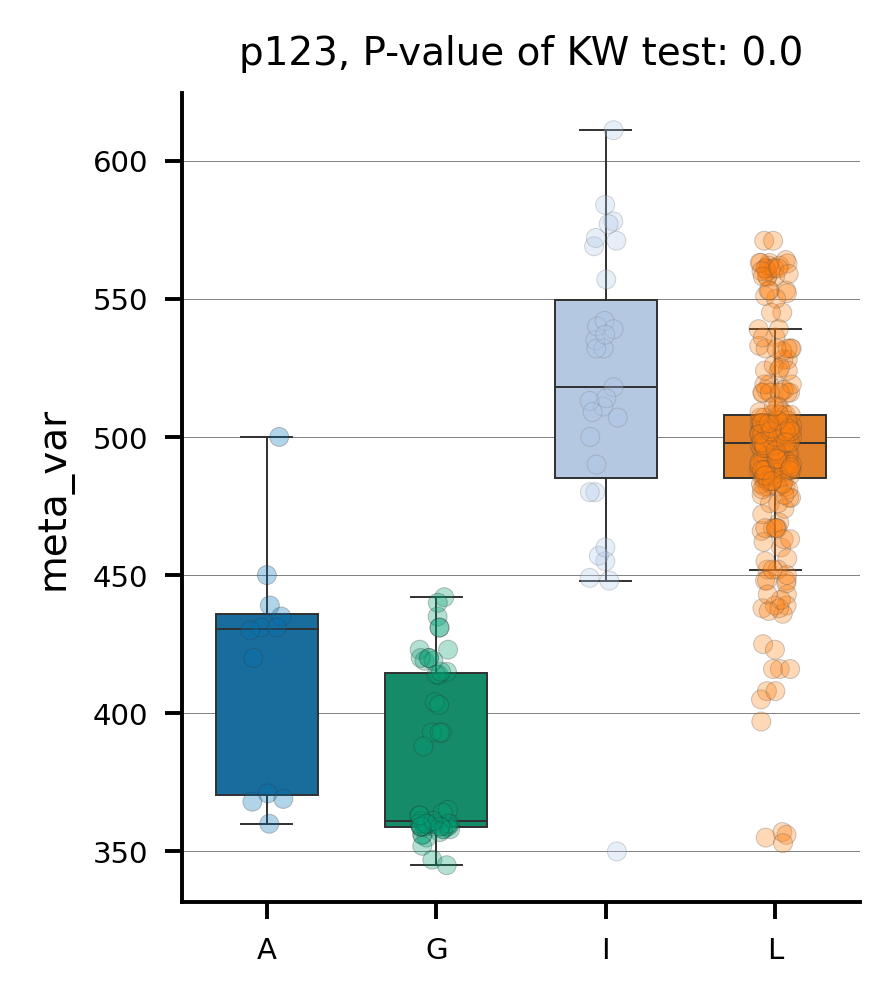

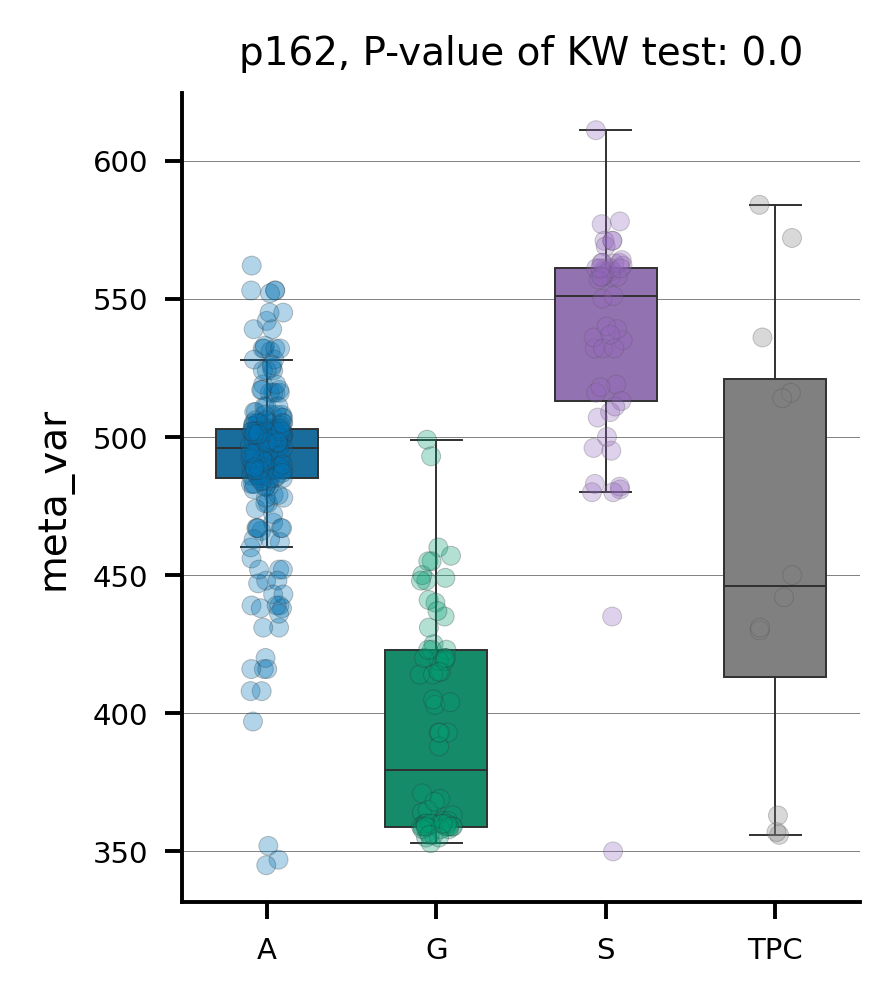

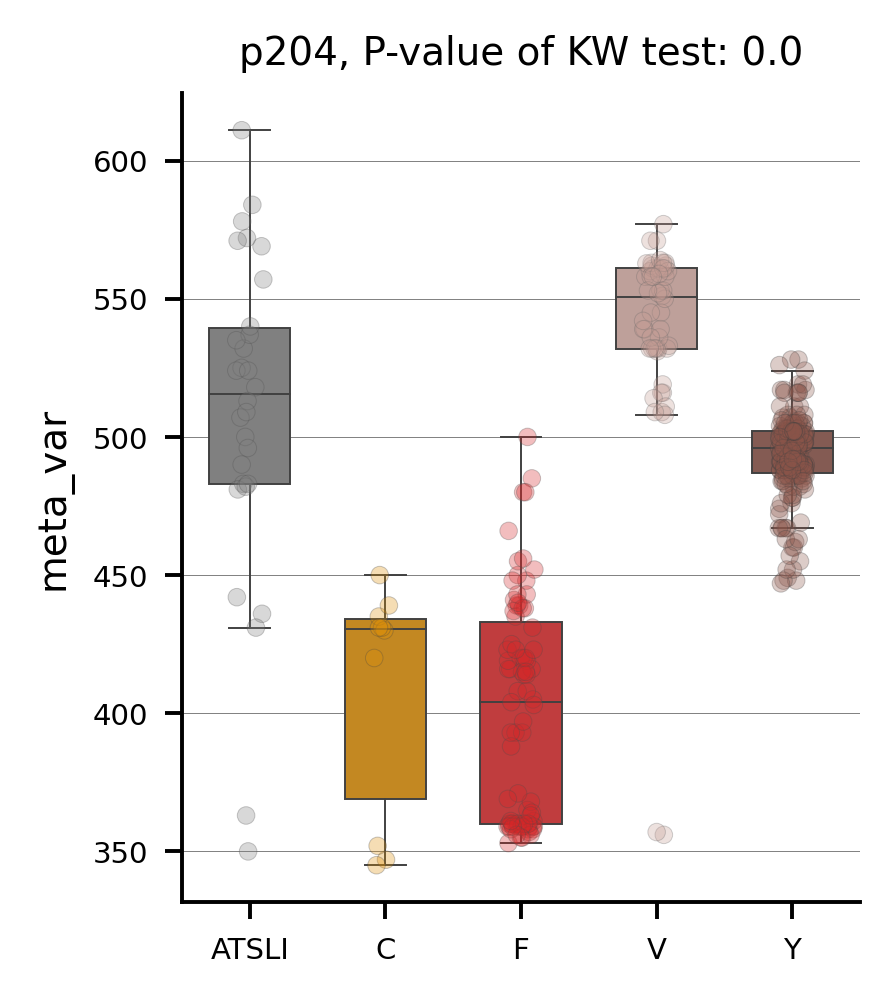

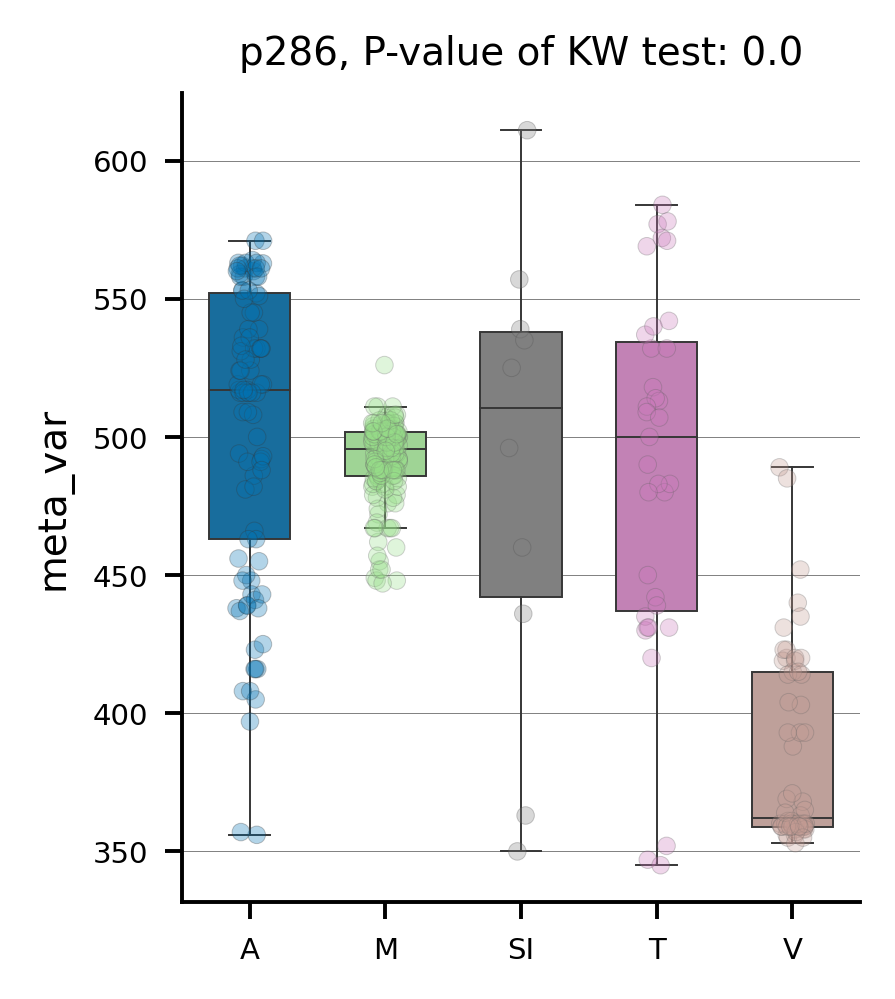

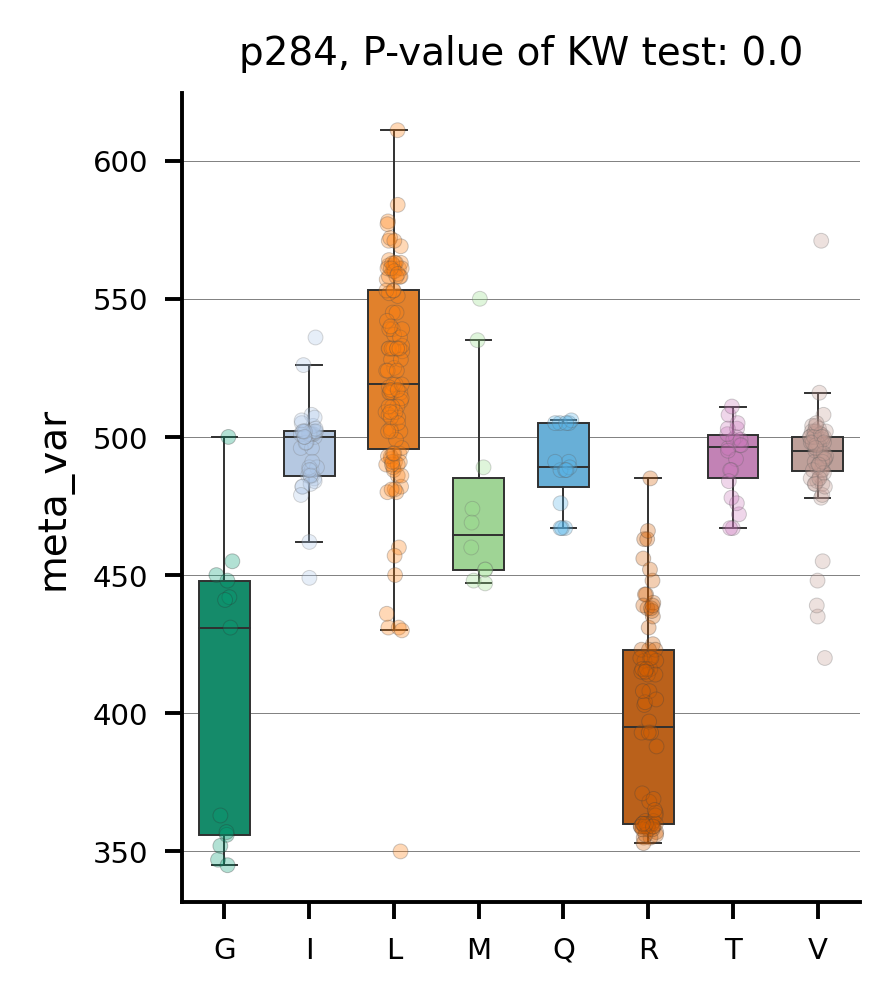

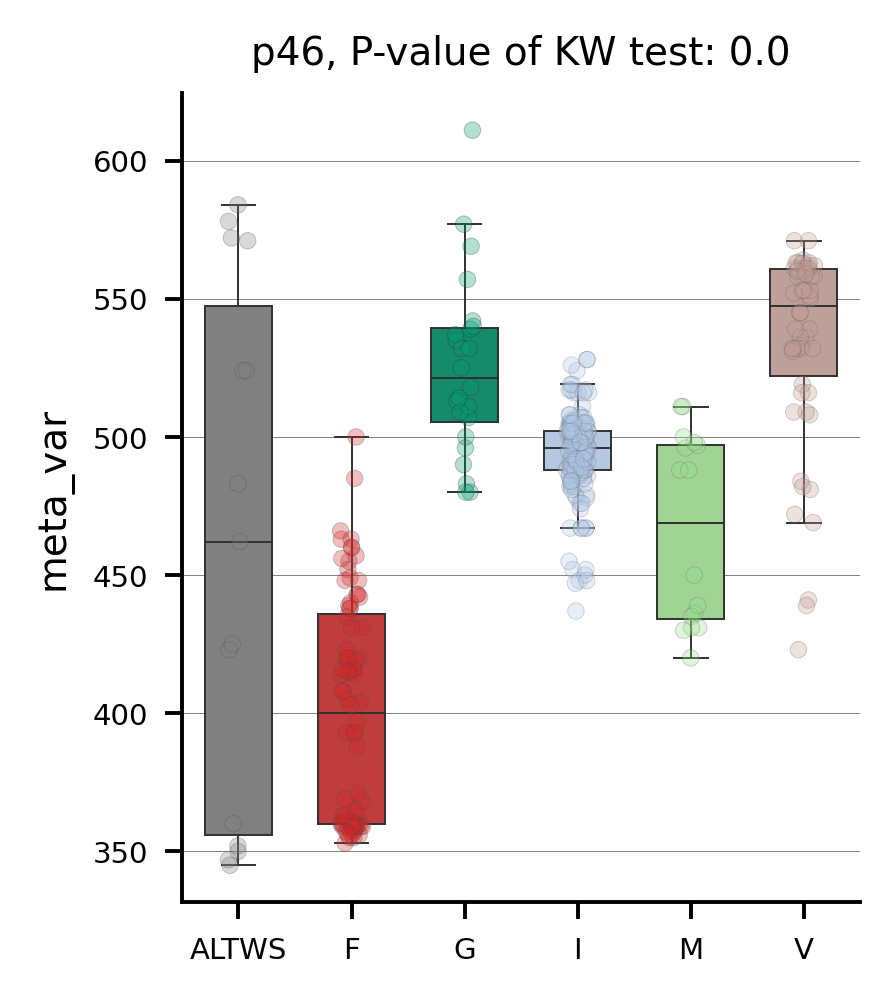

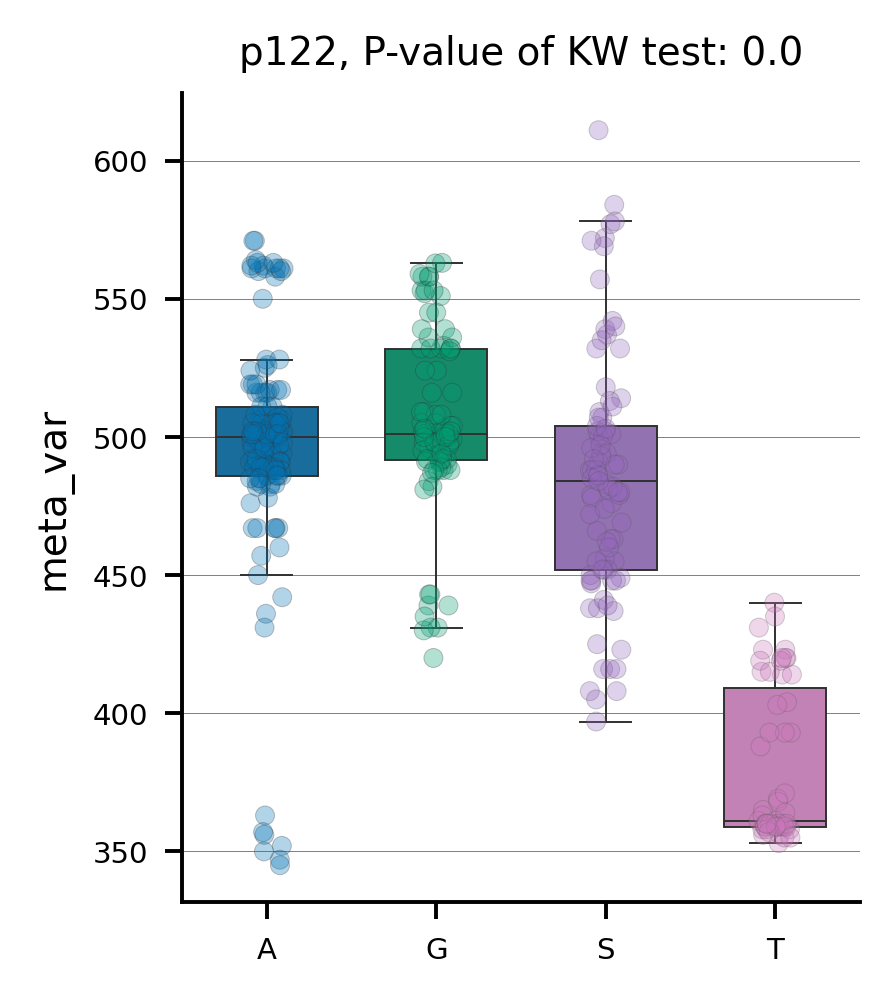

In [43]:
pl = plot_imp_all(final_models=top,
                  X_train=tr, y_train=y,
                  model_type = ana_type,
                  report_dir=report_dir, max_plots=10,
                  figsize=(2.5, 3))

In [52]:
from deepBreaks.utils import load_obj
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from scipy import stats
import re

In [94]:
top_per_mod = report_dir + '/' + mtml[2] + '.pkl'
load_top_mod = load_obj(top_per_mod)

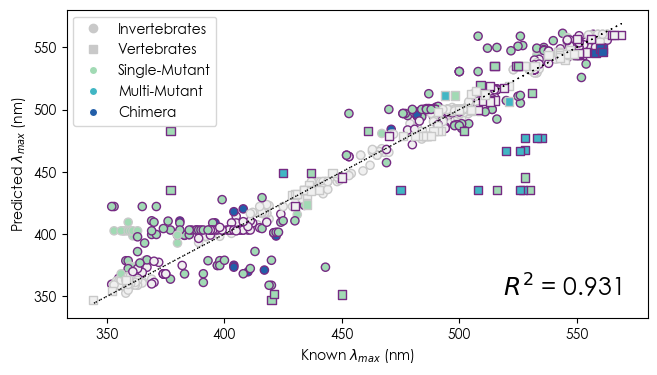

<Figure size 750x400 with 0 Axes>

In [95]:
inv = 'Chordata'
predictions = load_top_mod.predict(mut)
#print(predictions)
mut_metadata = path + "mut_meta.tsv"
mut_meta = pd.read_csv(mut_metadata, sep="\t", index_col = 0)
mut_meta = mut_meta.drop(mut_meta.index[0])
#mut_meta.head()
mut_meta['Prediction'] = predictions
mut_meta['Difference'] = mut_meta['Prediction'] - mut_meta['Lambda_Max']

mut_meta = mut_meta[['Species', 'Phylum','Opsin_Family', 'Accession','Mutations','Lambda_Max','Prediction','Difference']]
mut_meta.to_csv(path_or_buf= f'{report_dir}/mut_results.csv',index = 'Feature',mode="w")
true_lmax = mut_meta['Lambda_Max']
mut_meta.head()

wt_metadata = path + "wt_meta.tsv"
wt_meta = pd.read_csv(wt_metadata, sep="\t", index_col = 0)

edgecolors = []
colors = []
wt_acc_list = []
wt_lmax = []
mut_diff = []
mut_type = []
#append mutant type to list for error visuslization! We want to compare MSE of this vs. the wds model!
for ind in mut_meta.index:
    if abs(mut_meta['Difference'][ind]) >= 10:
        if inv != mut_meta['Phylum'][ind]:
            if '-' in str(mut_meta['Accession'][ind]):
                #dark blue - chimeras
                colors.append('#225ea8')
                mut_type.append('Chimera')
            elif str(mut_meta['Mutations'][ind]).count('_') >= 1 or str(mut_meta['Mutations'][ind]).count(',') >= 1:
                #blue - multiple mutations
                colors.append('#41b6c4')
                mut_type.append('Multiple Mutations')
            else:
                #green-blue - one mutation
                colors.append('#a1dab4')
                mut_type.append('Single Mutation')

        else:
            if '-' in str(mut_meta['Accession'][ind]):
                #dark blue - chimeras
                colors.append('#225ea8')
                mut_type.append('Chimera')

            elif str(mut_meta['Mutations'][ind]).count('_') >= 1 or str(mut_meta['Mutations'][ind]).count(',') >= 1:
                #green-blue - one mutation
                colors.append('#a1dab4')
                mut_type.append('Multiple Mutations')

            else:
                #green-blue - one mutation
                colors.append('#a1dab4')
                mut_type.append('Single Mutation')
    else:
        colors.append('#f0f0f0')
        if '-' in str(mut_meta['Accession'][ind]):
            mut_type.append('Chimera')
        elif str(mut_meta['Mutations'][ind]).count('_') >= 1 or str(mut_meta['Mutations'][ind]).count(',') >= 1:
            mut_type.append('Multiple Mutations')
        else:
            mut_type.append('Single Mutation')
    
    repeat_check = 0
    for wt in wt_meta.index:
        if repeat_check < 1:
            acc = wt_meta['Accession'][wt]
            acc = acc.split('.')[0]
            wt_acc = re.compile(f"^{acc}")

            if wt_acc.match(mut_meta['Accession'][ind]):
                if abs(wt_meta['Lambda_Max'][wt]-mut_meta['Lambda_Max'][ind]) >= 10:
                    edgecolors.append('#762a83')
                else:
                    edgecolors.append('#c9c9c9')
                diff = abs(wt_meta['Lambda_Max'][wt]-mut_meta['Lambda_Max'][ind])
                mut_diff.append(diff)
                wt_acc_list.append(wt_meta['Accession'][wt])
                wt_lmax.append(wt_meta['Lambda_Max'][wt])

                repeat_check += 1
            else:
                pass
        else:
            pass
    if repeat_check == 0:
        edgecolors.append('#c9c9c9')
        mut_diff.append('NA')
        wt_acc_list.append('No Match')
        wt_lmax.append('NA')
    else:
        pass

mut_meta['Mut_Type'] = mut_type
mut_meta['Colors'] = colors
mut_meta['Edge_Colors'] = edgecolors
mut_meta.to_csv(path_or_buf= f'{report_dir}/mut_results.csv',index_label=True,mode="w")

mut_wt_comp = pd.DataFrame()
mut_wt_comp["Mut_Acc"] = mut_meta["Accession"]
mut_wt_comp["WT_Acc"] = wt_acc_list
mut_wt_comp["Mut_Lmax"] = mut_meta["Lambda_Max"]
mut_wt_comp["WT_Lmax"] = wt_lmax
mut_wt_comp["Abs_Diff"] = mut_diff
mut_wt_comp["Edge_Colors"] = edgecolors
mut_wt_comp.to_csv(path_or_buf= f'{report_dir}/wt_mut_comp.csv',index_label=True,mode="w")

# Create a new column 'Marker' based on 'Phylum'
mut_meta['Marker'] = np.where(mut_meta['Phylum'] == inv, 'o', 's')

markers = mut_meta['Marker'].tolist()

#Adding in out desired font - feel free to change. :)
plt.rcParams['font.family'] = 'Century Gothic'
plt.rcParams["figure.figsize"] = [7.50, 4.00]
#plt.title("$λ_{max}$ Predictions for Unseen Mutant Data")

mask_o = np.array(markers) == 'o'
mask_s = np.array(markers) == 's'

# Create two separate scatter plots for invertebrates and vertebrates
scatter1 = plt.scatter(true_lmax[mask_o], predictions[mask_o], c=np.array(colors)[mask_o], ec=np.array(edgecolors)[mask_o], edgecolors='k', s=35, alpha=1.0, marker='o', label='Vertebrates')
scatter2 = plt.scatter(true_lmax[mask_s], predictions[mask_s], c=np.array(colors)[mask_s], ec=np.array(edgecolors)[mask_s], edgecolors='k', s=35, alpha=1.0, marker='s', label='Inertebrates')


plt.plot(true_lmax, true_lmax, c='k', linewidth='1.0', ls='--', dashes=(1, 3))
plt.xlabel('Known $λ_{max}$ (nm)')
plt.ylabel('Predicted $λ_{max}$ (nm)')
plt.annotate(f"$R^2$ = {load_top_mod.score(mut, true_lmax):.3f}", (max(true_lmax), min(predictions)), ha='right', va='bottom', fontsize=18, c='k')
# Custom legend handles and labels
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#c9c9c9', markeredgecolor= '#c9c9c9', markersize=6),
                  plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='#c9c9c9', markeredgecolor= '#c9c9c9', markersize=6),
                  plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='#a1dab4', markersize=12), 
                  plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='#41b6c4', markersize=12), 
                  plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='#225ea8', markersize=12)]
legend_labels = ['Invertebrates', 'Vertebrates', 'Single-Mutant', 'Multi-Mutant', 'Chimera']

# Add legend on the top left corner
plt.legend(handles=legend_handles, labels=legend_labels, loc='upper left')

fileout = f'{report_dir}/final_wt_mut_test_v3.pdf'
plt.savefig(fileout)
fileout = 'final_wt_mut_test_v3.svg'
plt.savefig(fileout, format='svg', bbox_inches='tight')
fileout = 'final_wt_mut_test_v3.png'
plt.savefig(fileout, format='png',  dpi=300)
plt.show()
plt.clf()
plt.show()

model_testing_report = f'{report_dir}/model_testing report.tsv'

base_rsq = load_top_mod.score(mut, true_lmax)
#print(base_rsq)

base_mae = mean_absolute_error(predictions, true_lmax)
#print(base_mae)

base_mape = mean_absolute_percentage_error(predictions, true_lmax)
#print(base_mape)

base_sqe = mean_squared_error(predictions, true_lmax)
#print(base_sqe)

base_rsqe = mean_squared_error(predictions, true_lmax, squared=False)
#print(base_rsqe)

with open(model_testing_report, 'w') as f:
    f.write(f'Base Model R^2\tBase Model MAE\tBase Model MAPE\tBase Model SQE\tBase Model RSQE\n')
    f.write(f'{str(base_rsq)}\t{str(base_mae)}\t{str(base_mape)}\t{str(base_sqe)}\t{str(base_rsqe)}')

In [83]:
mut_meta

Species    Phylum Opsin_Family  \
M1    Tachyglossus_aculeatus  Chordata          Rh1   
M2    Tachyglossus_aculeatus  Chordata          Rh1   
M3    Tachyglossus_aculeatus  Chordata          Rh1   
M4                Bos_taurus  Chordata          Rh1   
M5                Bos_taurus  Chordata          Rh1   
...                      ...       ...          ...   
M757            Mus_musculus  Chordata          RH2   
M758            Mus_musculus  Chordata          RH2   
M759            Mus_musculus  Chordata          RH2   
M760            Homo_sapiens  Chordata          LWS   
M761            Homo_sapiens  Chordata          LWS   

                         Accession          Mutations  Lambda_Max  Prediction  \
M1                   JX103830_N83D               N83D       503.8  498.689529   
M2                  JX103830_T158A              T158A       498.0  498.689529   
M3                  JX103830_F169A              F169A       499.4  498.689529   
M4               NM_001014890_D83G               D83G       501.5  501.421514   
M5               NM_001014890_D83N               D83N       491.5  501.421514   
...                            ...                ...         ...         ...   
M757              AF011389.1_S308A              S308A       526.0  513.296934   
M758  AF011389.1_Y277F,T285A,S308A  Y277F,T285A,S308A       506.0  511.779077   
M759        AF011389.1_Y277F,T285A        Y277F,T285A       487.0  511.779077   
M760              AH005298.2_H197Y              H197Y       526.0  561.020735   
M761        AH005298.2_H197Y,A308S        H197Y,A308S       508.0  561.020735   

      Difference            Mut_Type   Colors Edge_Colors Marker  
M1     -5.110471     Single Mutation  #f0f0f0     #c9c9c9      o  
M2      0.689529     Single Mutation  #f0f0f0     #c9c9c9      o  
M3     -0.710471     Single Mutation  #f0f0f0     #c9c9c9      o  
M4     -0.078486     Single Mutation  #f0f0f0     #c9c9c9      o  
M5      9.921514     Single Mutation  #f0f0f0     #c9c9c9      o  
...          ...                 ...      ...         ...    ...  
M757  -12.703066     Single Mutation  #a1dab4     #762a83      o  
M758    5.779077  Multiple Mutations  #f0f0f0     #c9c9c9      o  
M759   24.779077  Multiple Mutations  #a1dab4     #762a83      o  
M760   35.020735     Single Mutation  #a1dab4     #762a83      o  
M761   53.020735  Multiple Mutations  #a1dab4     #762a83      o  

[761 rows x 12 columns]

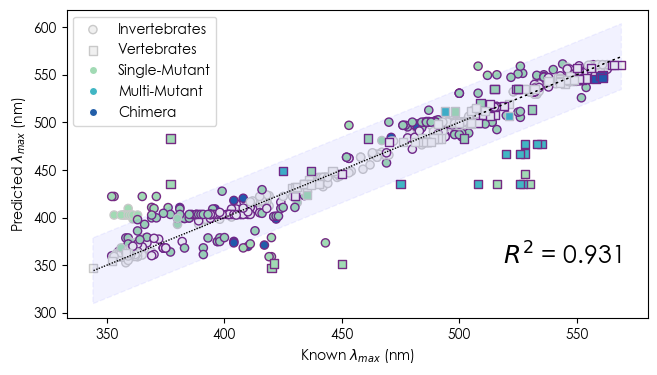

<Figure size 750x400 with 0 Axes>

In [96]:
# Function to get prediction interval for a linear regression
def get_prediction_interval(prediction, y_test, test_predictions, pi=0.95):
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)
    
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
    
    lower, upper = prediction - interval, prediction + interval
    return lower, prediction, upper

# Scatter plot
# Create two separate scatter plots for invertebrates and vertebrates
scatter1 = plt.scatter(true_lmax[mask_o], predictions[mask_o], c=np.array(colors)[mask_o], ec=np.array(edgecolors)[mask_o], edgecolors='k', s=35, alpha=1.0, marker='o', label='Vertebrates')
scatter2 = plt.scatter(true_lmax[mask_s], predictions[mask_s], c=np.array(colors)[mask_s], ec=np.array(edgecolors)[mask_s], edgecolors='k', s=35, alpha=1.0, marker='s', label='Inertebrates')


plt.plot(true_lmax, true_lmax, c='k', linewidth='1.0', ls='--', dashes=(1, 3))
plt.xlabel('Known $λ_{max}$ (nm)')
plt.ylabel('Predicted $λ_{max}$ (nm)')
plt.annotate(f"$R^2$ = {load_top_mod.score(mut, true_lmax):.3f}", (max(true_lmax), min(predictions)), ha='right', va='bottom', fontsize=18, c='k')
# Custom legend handles and labels
legend_handles = [scatter1, scatter2, plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='#a1dab4', markersize=12), plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='#41b6c4', markersize=12), plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='#225ea8', markersize=12)]
legend_labels = ['Invertebrates', 'Vertebrates', 'Single-Mutant', 'Multi-Mutant', 'Chimera']

# Add legend on the top left corner
plt.legend(handles=legend_handles, labels=legend_labels, loc='upper left')

# Confidence ribbon using prediction interval
# Sort data by 'Lambda_Max' for smoother ribbon
sorted_indices = np.argsort(mut_meta['Lambda_Max'])
sorted_lambda_max = mut_meta['Lambda_Max'].values[sorted_indices]
sorted_prediction = mut_meta['Prediction'].values[sorted_indices]
lower_vet = []
upper_vet = []
for i in sorted_lambda_max:
    lower, prediction, upper = get_prediction_interval(i, mut_meta['Lambda_Max'], mut_meta['Prediction'])
    lower_vet.append(lower)
    upper_vet.append(upper)

# Plotting the confidence ribbon directly using fill_between
plt.fill_between(sorted_lambda_max, lower_vet, upper_vet, color='blue', alpha=0.05, ls = '--')

fileout = f'{report_dir}/final_wt_mut_test_v3.pdf'
plt.savefig(fileout)
fileout = 'final_wt_mut_test_v3.svg'
plt.savefig(fileout, format='svg', bbox_inches='tight')
fileout = 'final_wt_mut_test_v3.png'
plt.savefig(fileout, format='png',  dpi=300)
plt.show()
plt.clf()
plt.show()

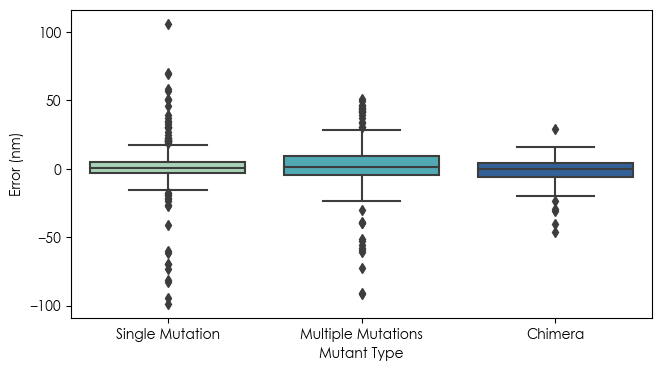

<Figure size 750x400 with 0 Axes>

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns  # Optional, but it enhances the aesthetics of plots
import pandas as pd

plt.figure(figsize = [7.50, 4.00])
#palette = sns.color_palette("Set2")
palette = ['#a1dab4','#41b6c4','#225ea8']

sns.boxplot(x='Mut_Type', y='Difference', data=mut_meta, dodge=False, palette=palette, order = ['Single Mutation', 'Multiple Mutations', 'Chimera'])
# Customize axis labels
plt.xlabel('Mutant Type')
plt.ylabel('Error (nm)')
#save file
fileout = 'wt_iter_test_err_bxplts.png'
plt.savefig(fileout, format = 'png', dpi = 300)
fileout = 'wt_iter_test_err_bxplts.svg'
plt.savefig(fileout, format='svg', bbox_inches='tight')
plt.show()
plt.clf()
plt.show()


# <font color=red>STEP 4: Translate Candidate STSs</font> 
## Optional step IF running the classifier model, but could still be useful.
### To find CSTSs, got to the deepBreaks output folder and find the excel sheet 'avg_top_models_feature_importance'
### Sort the top model's feature importance column by 'largest-to-smallest' and take x# of those positions.

In [86]:
import pandas as pd
import os

In [87]:
#STEP 4: Translate Candidate STSs 
#translate candidate STSs to the bovine or squid equivalent 
    #bovine and squid sequence dataframes were saved earlier and are called again here
m = 0
tm = ''
k=0
gaps=0
#import importance_report.csv from report_dir
true_pos = []
aa = []
tmd = []
df = pd.read_csv(f'{report_dir}\importance_report.csv')
#take the list of important sites and translate them to the bovine standard equivalent, 
#we do this by taking the site number and subtracting the number of '-' between the start of the sequence and the desired site. 
for rows in reference_seq.values:  
    rows = str(rows)
    #print(rows)
    if rows == 'nan':
    #We want to write the 'true_pos', 'aa', and 'TMD' to the 'importance_report' csv file
        gaps += 1
        k += 1
        true_pos.append('NA')
        aa.append('-')
        tmd.append('NA')
    else:
        #print("The number of gaps is " + str(gaps))
        k+=1
        trans_site = k - gaps
        if ref_seq_name == 'bovine':
            if trans_site in range(3,37):
                tm = 'N-Termina'
            elif trans_site in range(37,62):
                tm = '1'
            elif trans_site in range(74,96):
                tm = '2'
            elif trans_site in range(111,133):
                tm = '3'
            elif trans_site in range(153,174):
                tm = '4'
            elif trans_site in range(203,225):
                tm = '5'
            elif trans_site in range(253,275):
                tm = '6'
            elif trans_site in range(287,309):
                tm = '7'
            else:
                tm = 'CT/EC'
        else:
            if trans_site in range(3,34):
                tm = 'N-Termina'
            elif trans_site in range(34,59):
                tm = '1'
            elif trans_site in range(71,97):
                tm = '2'
            elif trans_site in range(110,132):
                tm = '3'
            elif trans_site in range(152,173):
                tm = '4'
            elif trans_site in range(200,225):
                tm = '5'
            elif trans_site in range(262,284):
                tm = '6'
            elif trans_site in range(294,315):
                tm = '7'
            else:
                tm = 'CT/EC'                
        
        true_pos.append(str(trans_site))
        aa.append(rows)
        tmd.append(tm)
true_pos.pop()
aa.pop()
tmd.pop()

df['true_position'] = true_pos
df['TMD'] = tmd
df['amino_acid'] = aa
df.to_csv(path_or_buf= os.path.join(report_dir,r'importance_report.csv'),index = 'Feature',mode="w")
#df.head()
